# FYP OSNR: DATA ANALYSIS

Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

## MATCHING SHAPES

Since the signals are all taken over time, the channels we want to look at can be taken at different points in time depending on the measurement. However, the general shape should be the same (except for when we start turning off channels). The following function `get_match` takes the times, signal, and on-signal, and compares the signal to the on-signal. It then shifts the signal by one timestep until its passed over every timestep and takes the most accurate match. The `get_match_window` function does the same but matches an entire function to just a window of another signal:

In [2]:
def get_match(t, signal, signal_on):
    # set sum of squared errors to infinity
    sse = np.inf
    # initialise the signal we return as our current signal
    new_signal = signal.copy()
    
    # loop through each element
    for i in range(len(t)):
        # roll the array so that i values at end are moved to start
        test_signal = np.roll(signal, i)
        # get the sse of this test signal compared to the on signal
        test_sse = sum(np.abs(test_signal - signal_on)**2)
        # if the new sse is smaller than previous
        if test_sse < sse:
            # set new sse
            sse = test_sse
            # set new signal
            new_signal = test_signal
    
    return new_signal

def get_match_window(t, signal, signal_window):
    # set sum of squared errors to infinity
    sse = np.inf
    # initialise the signal we return as our current signal
    new_signal = signal.copy()
    
    # loop through each element
    for i in range(len(t)):
        # roll the array so that i values at end are moved to start
        # then only look at the same number of values as the signal window
        # this means that we are directly the window to the signal
        test_signal = np.roll(signal, i)[:len(signal_window)]
        # get the sse of this test signal compared to the window signal
        test_sse = sum(np.abs(test_signal - signal_window)**2)
        # if the new sse is smaller than previous
        if test_sse < sse:
            # set new sse
            sse = test_sse
            # set new signal
            # ignoring windowing
            new_signal = np.roll(signal, i)
    
    return new_signal

The on-signal we want to use for comparison is as follows. We also define the window we wish to look at, roughly in the range of the markers (channel 81 to 87):

Text(0.5, 0, 'Time (s)')

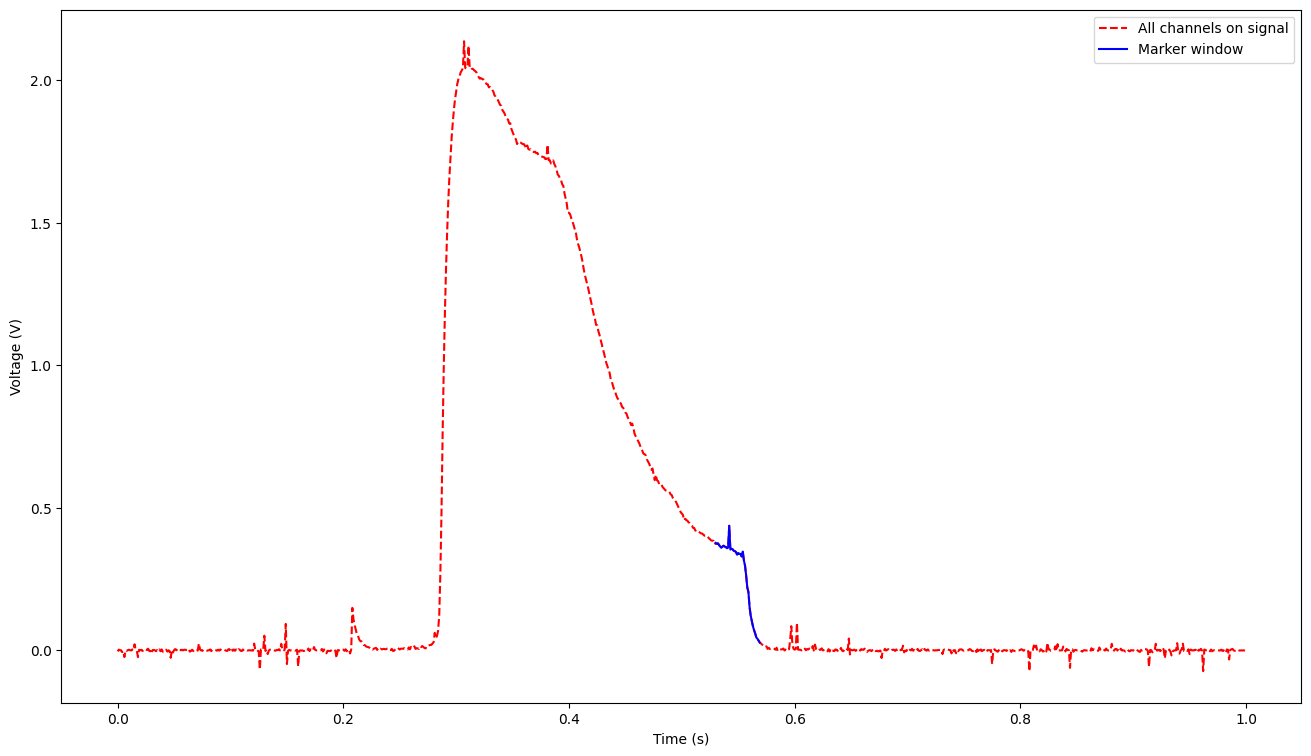

In [3]:
# import the on data from the text file
t_on, signal_on = np.loadtxt(f'Data/on_channels/reading_003.txt', delimiter=',', skiprows=1).T
# fix data by only taking first second of it (as it is periodic with 1s), total data is 2s long so half it
t_on = t_on[:len(t_on)//2]
signal_on = signal_on[:len(signal_on)//2]

# the markers to use
marker_81 = 530
marker_87 = 570
# create an array of only this window of the on signal
marker_window = signal_on[marker_81:marker_87]

# PLOTTING
fig, ax = plt.subplots(
    1, 1,
    figsize=(16, 9)
)

# Plot the fixed signal with the on signal
ax.plot(t_on, signal_on, label=f'All channels on signal', color='r', ls='--', zorder=0)
ax.plot(t_on[marker_81:marker_87], marker_window, label=f'Marker window', color='b', zorder=1)
ax.legend()

ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (s)')

We can convert time to frequency by taking two known points in frequency and comparing to the time value obtained. This was done for the two peaks in `Data/every_k/reading_024.txt`:

[0.292 0.49  0.512 0.514 0.516 0.518 0.521 0.529 0.532 0.538 0.541 0.544
 0.546 0.551]


Text(0.5, 0, 'Frequency (THz)')

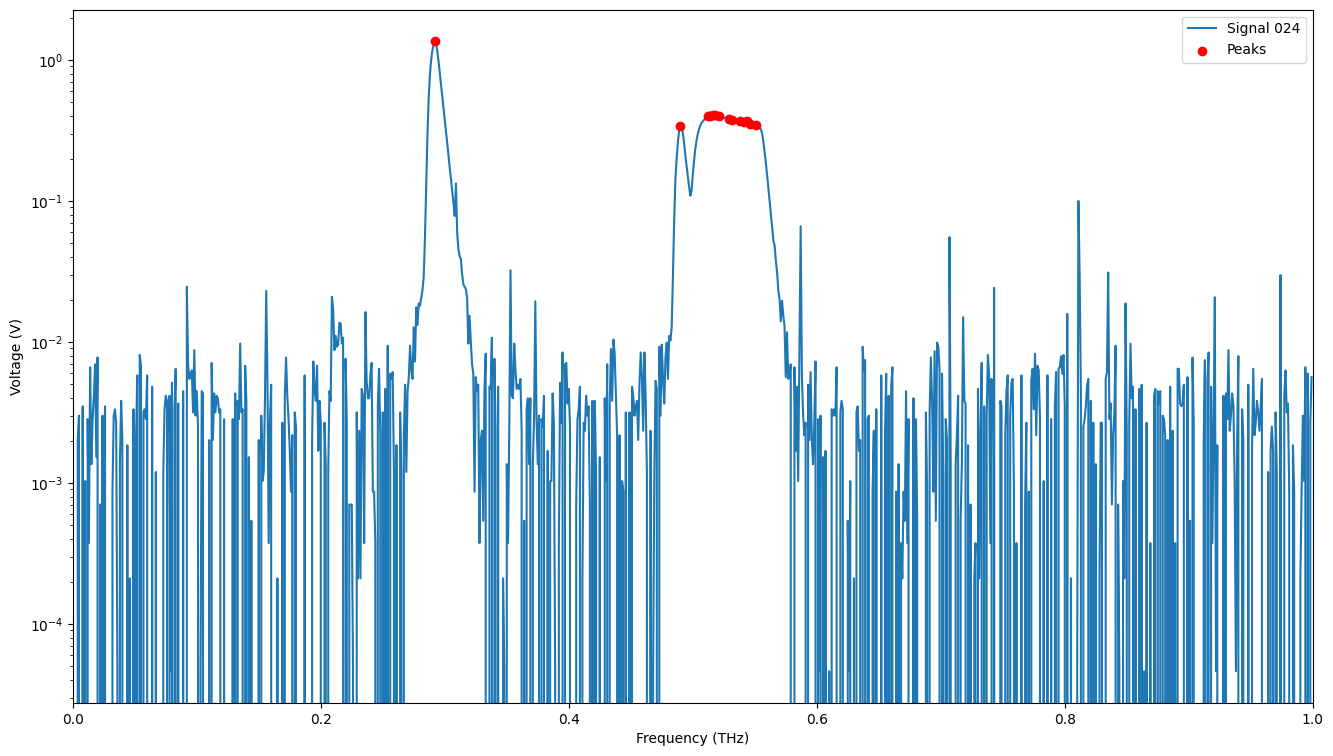

In [4]:
# import the data from the text file
t, signal = np.loadtxt(f'Data/every_k/reading_024.txt', delimiter=',', skiprows=1).T
# fix data by only taking first second of it (as it is periodic with 1s), total data is 2s long so half it
t = t[:len(t)//2]
signal = signal[:len(signal)//2]

# fix the signal so it is in the center
# do this by matching the on signal window with the signal
# but must roll by the marker_81 value to make sure we index properly
fixed_signal = np.roll(get_match_window(t, signal, marker_window), marker_81)

peak_indices, _ = find_peaks(fixed_signal, height=0.2)

with np.printoptions(threshold=np.inf):
    print(t[peak_indices])

# PLOTTING
fig, ax = plt.subplots(
    1, 1,
    figsize=(16, 9)
)

# Plot the fixed signal with the on signal
ax.plot(t, fixed_signal, label=f'Signal 024', zorder=1)
ax.scatter(t[peak_indices], fixed_signal[peak_indices], color='r', label=f'Peaks', zorder=2)

ax.legend()

ax.set_xlim(0, 1)

ax.set_yscale('log')

ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Frequency (THz)')

`signal_024`  
Time (s) -> Frequency (THz): 0.292 -> 194.3945  
Time (s) -> Frequency (THz): 0.49 -> 195.696  

In [5]:
# points defining
t1, t2 = 0.292, 0.49
freq1, freq2 = 194.3945, 195.696

# parameters of line
slope = (freq2 - freq1) / (t2 - t1)
intercept = freq1 - slope * t1

# make as a function
s_to_THz = lambda t: slope * t + intercept

Convert voltage to dBm:

In [6]:
# max of watts to max of voltage
watt_conversion = 4.2150234972104395e-07 / 1.421254738842842
print(watt_conversion)

# create a function to convert voltage to dBm
V_to_dBm = lambda voltage: 10 * np.log10(1000 * voltage * watt_conversion)

2.965705852732797e-07


We can then pass through many readings and get this fixed signal, plotting it with the on-signal:

C:\Users\seani\AppData\Local\Temp\ipykernel_12688\3936326195.py:6: RuntimeWarning: invalid value encountered in log10
  V_to_dBm = lambda voltage: 10 * np.log10(1000 * voltage * watt_conversion)


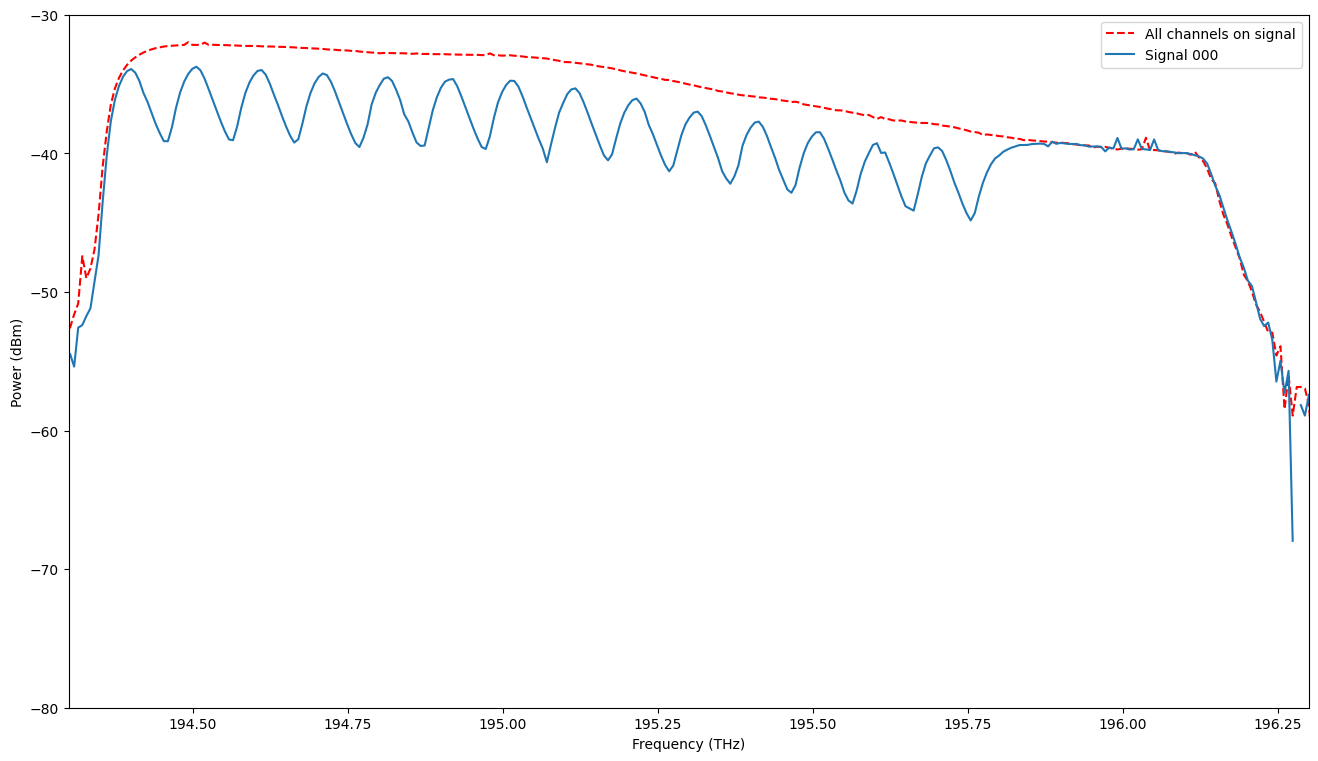

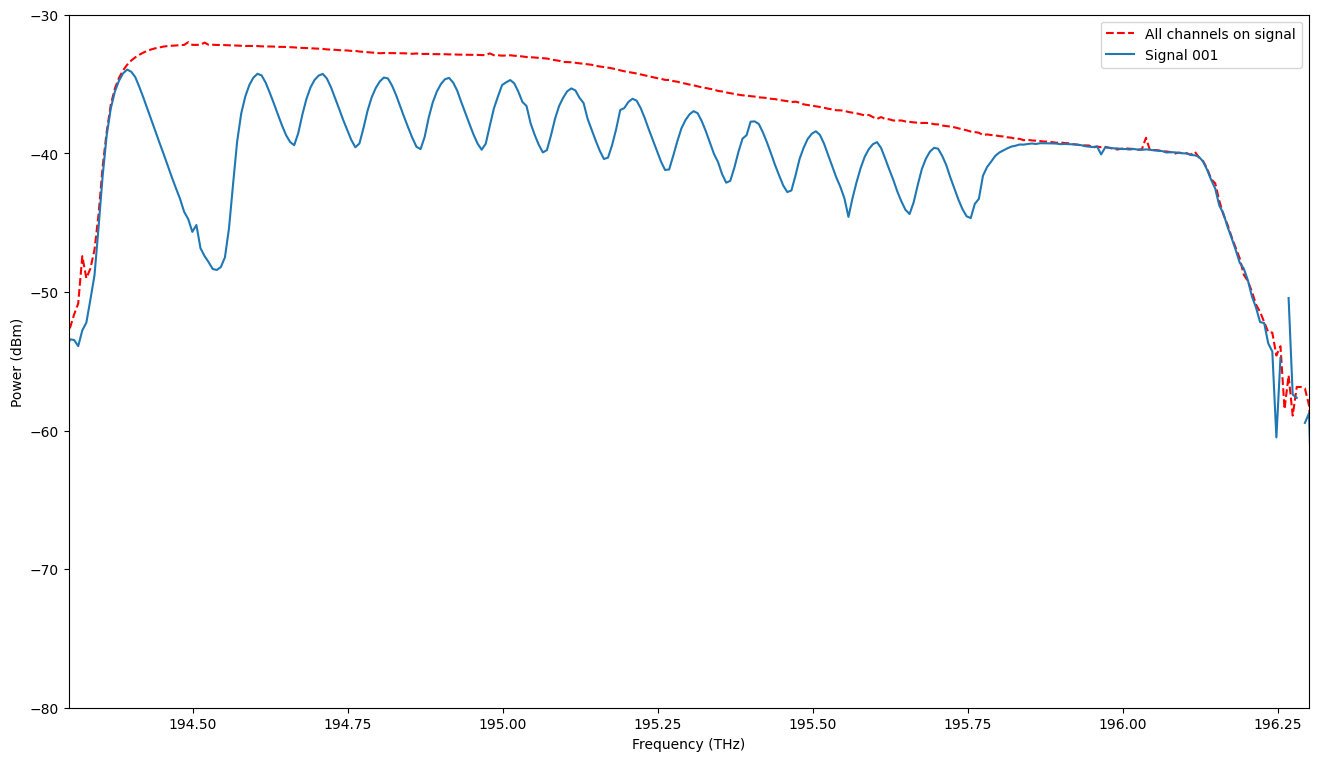

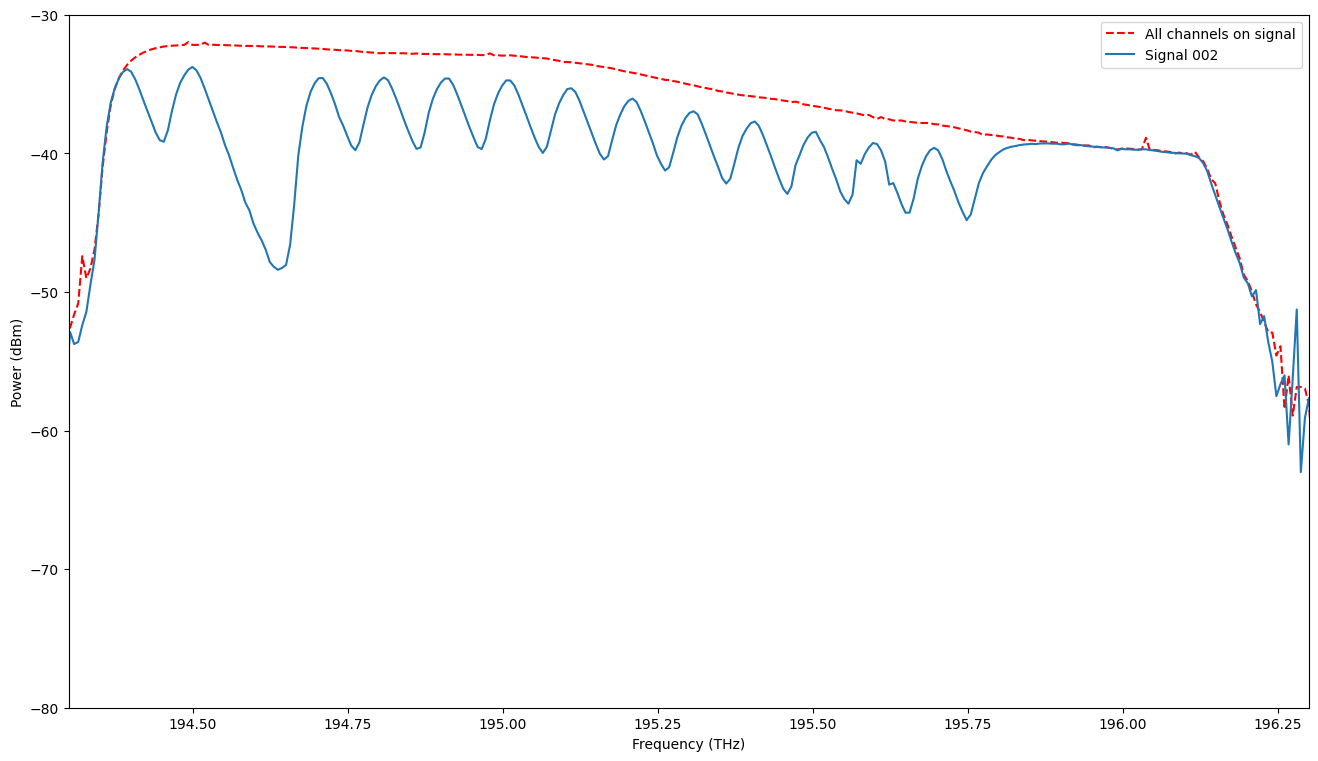

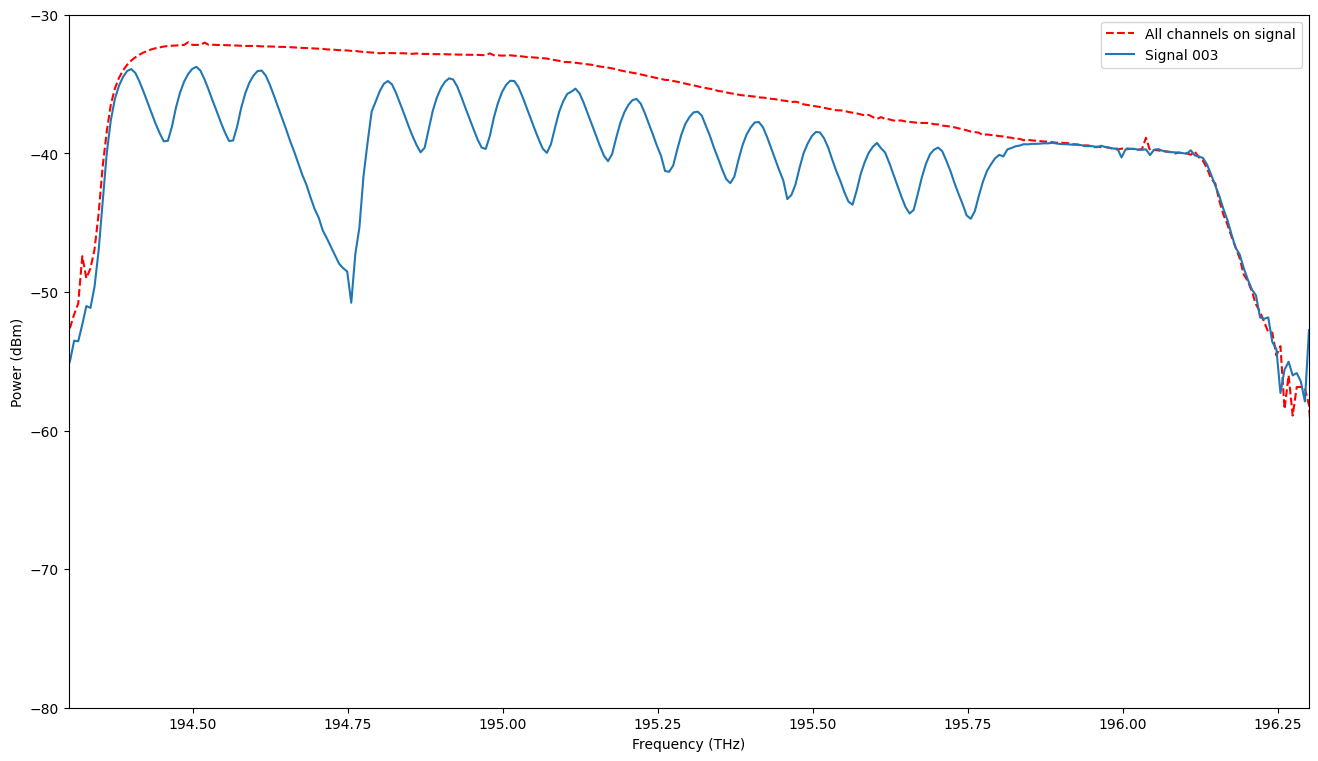

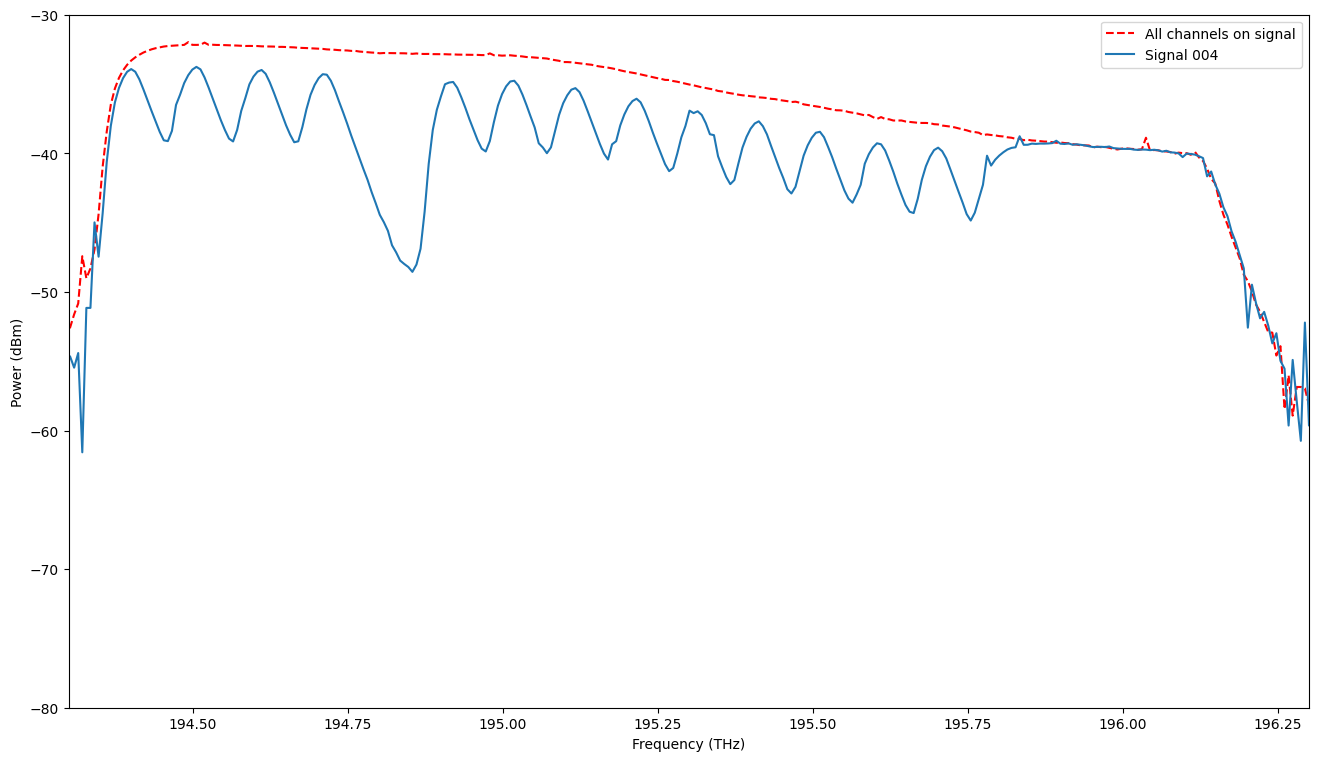

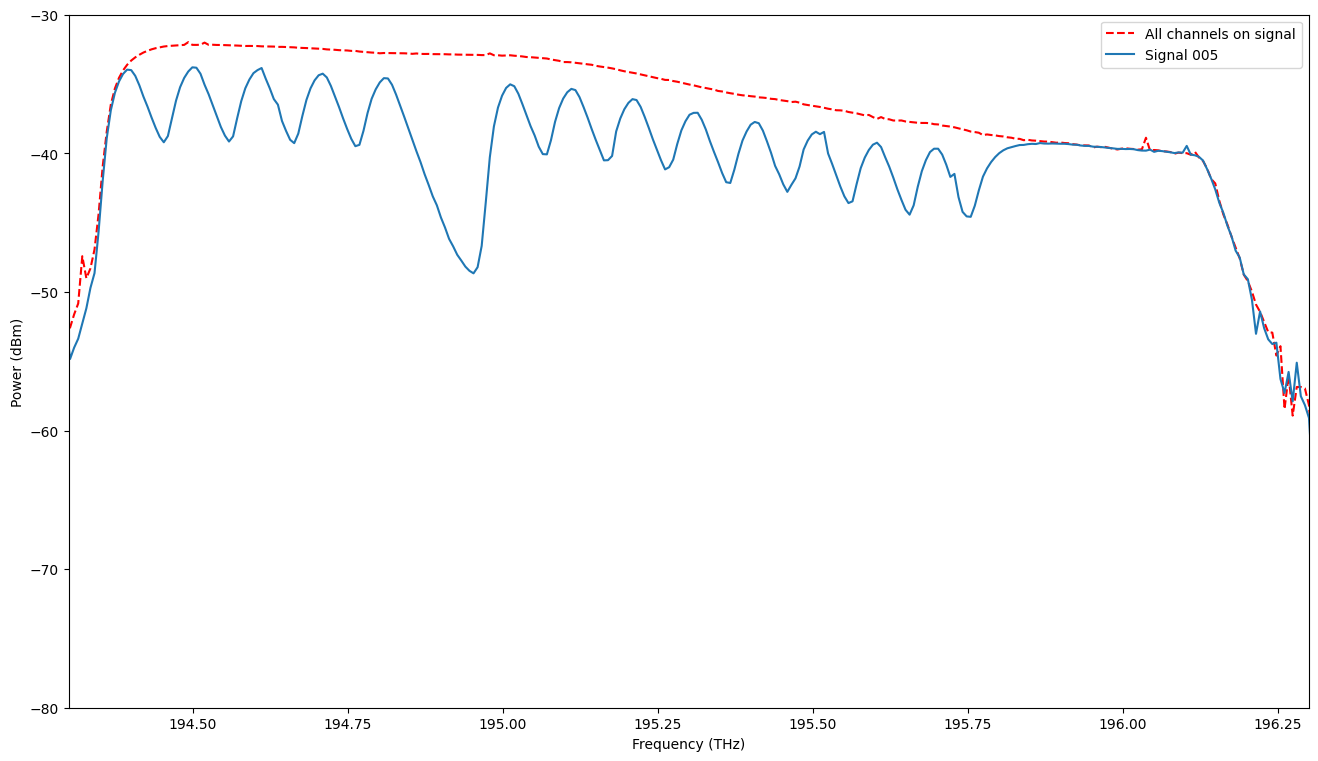

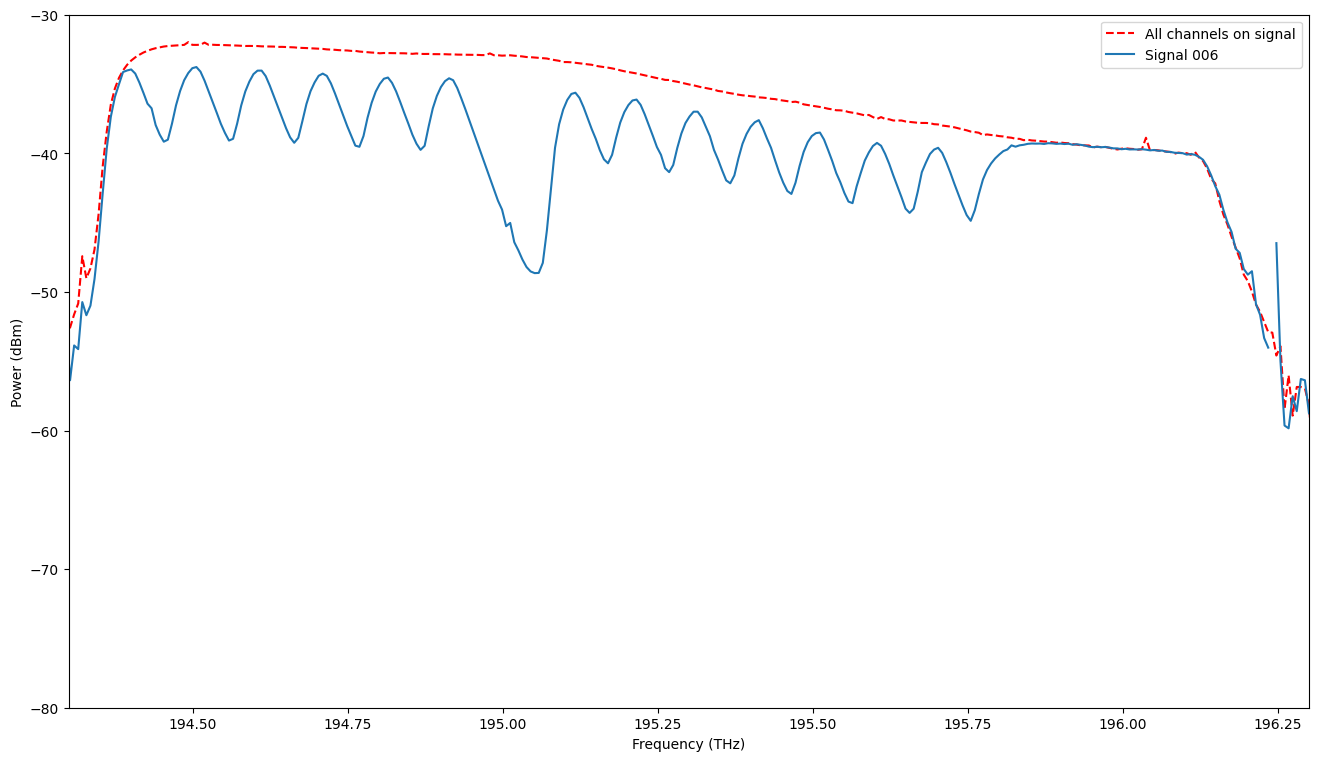

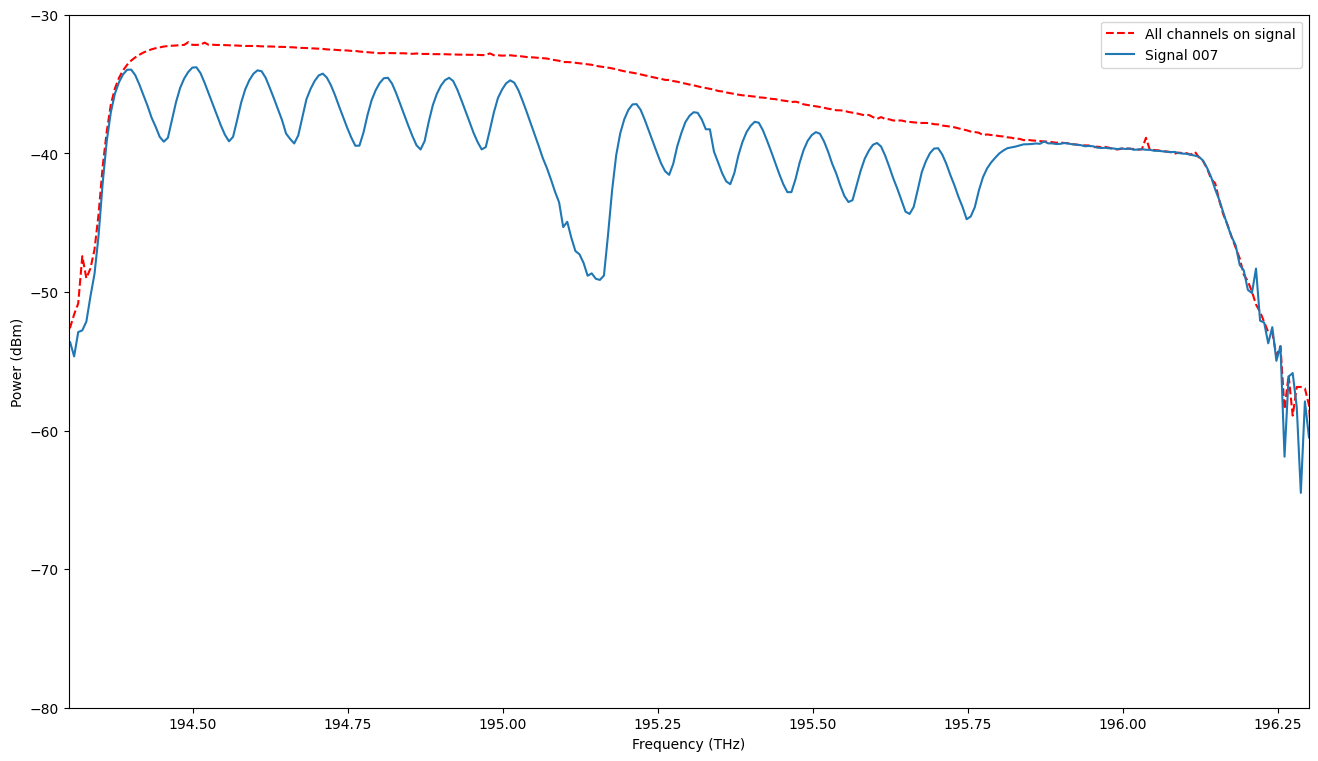

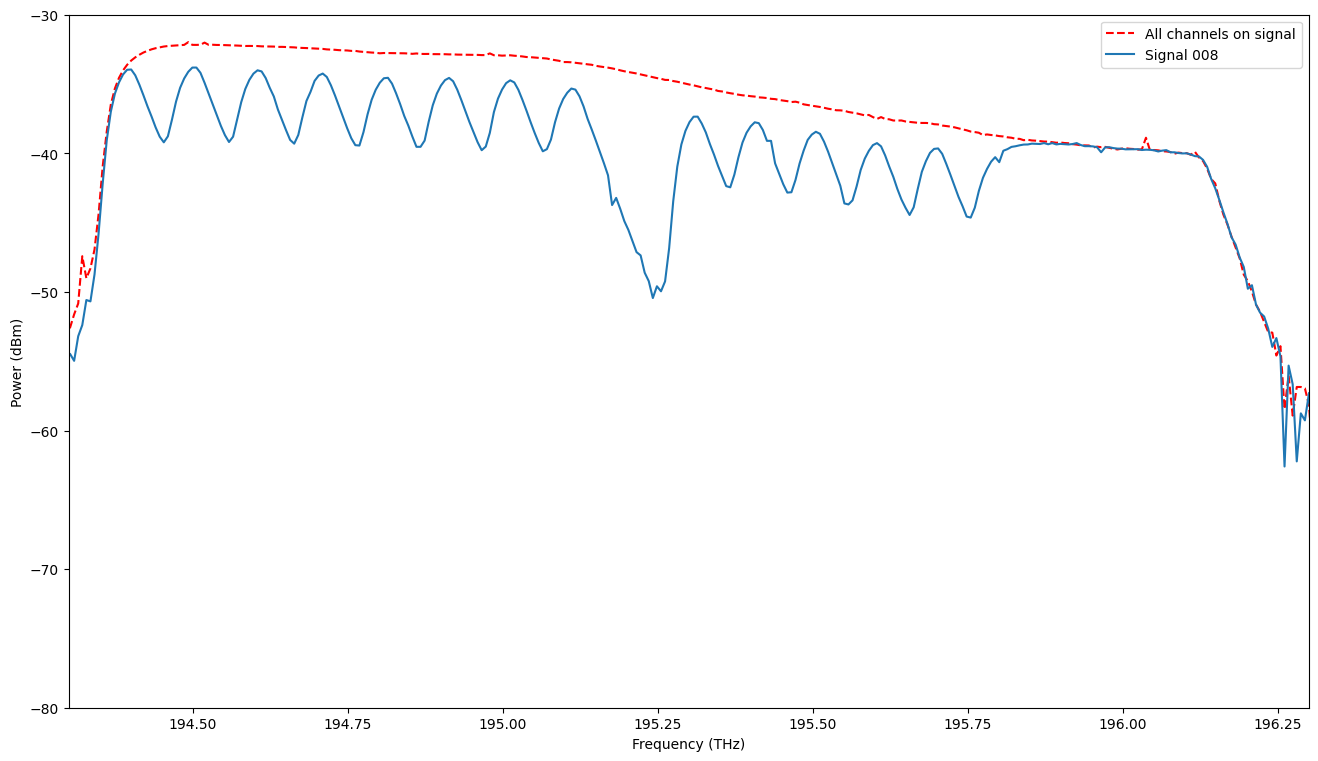

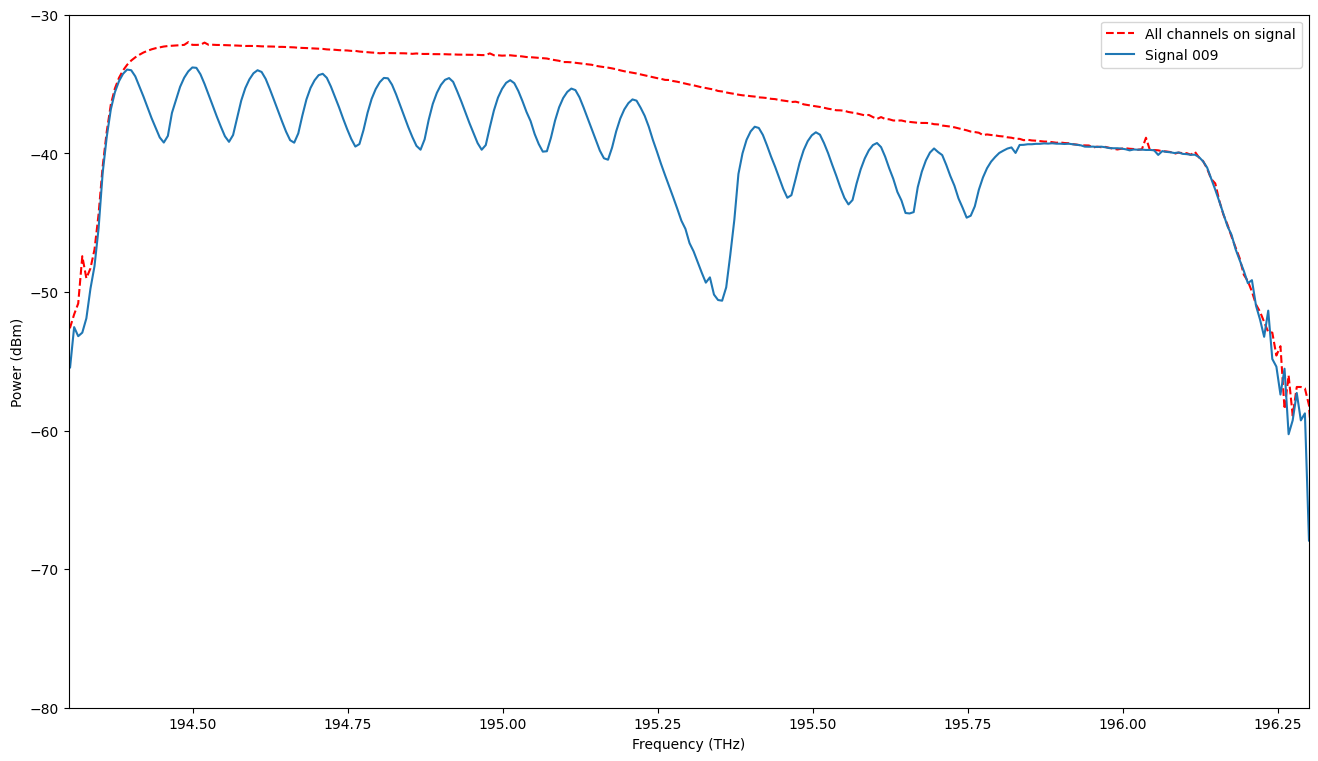

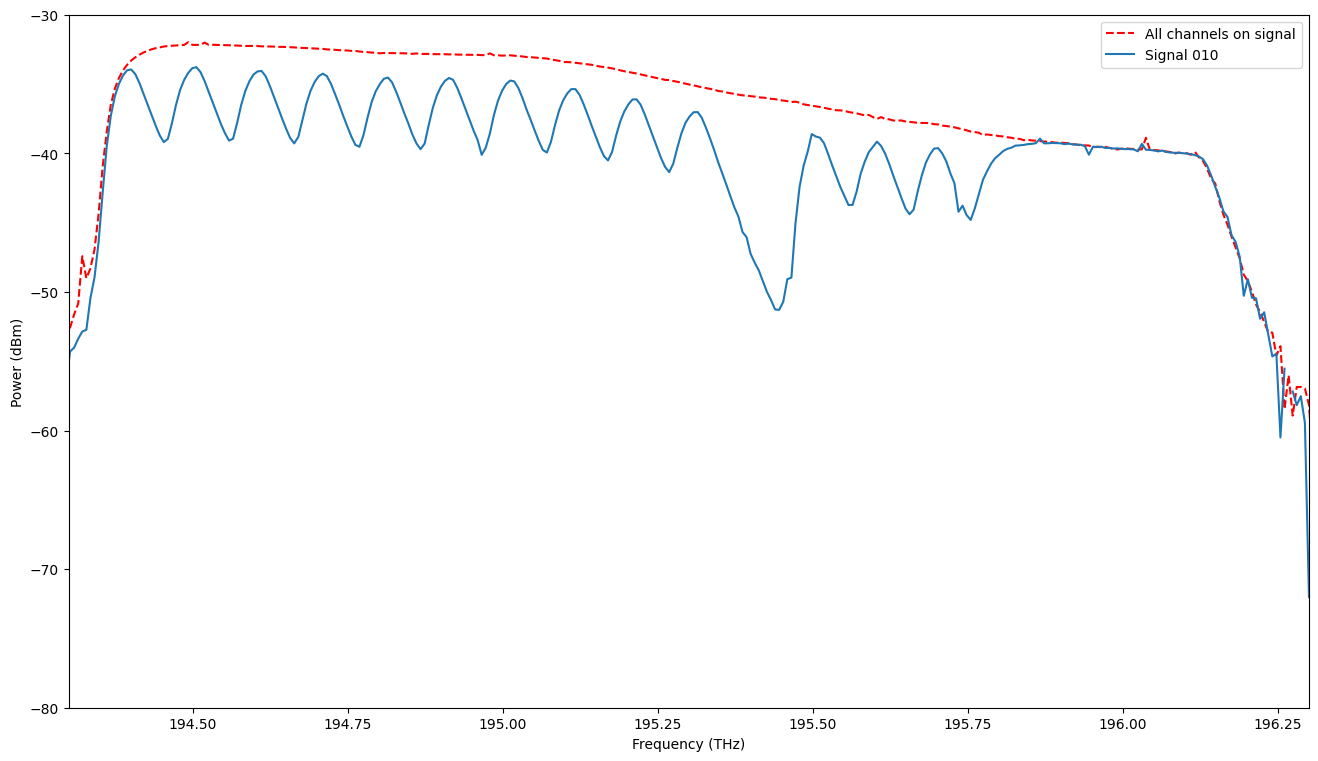

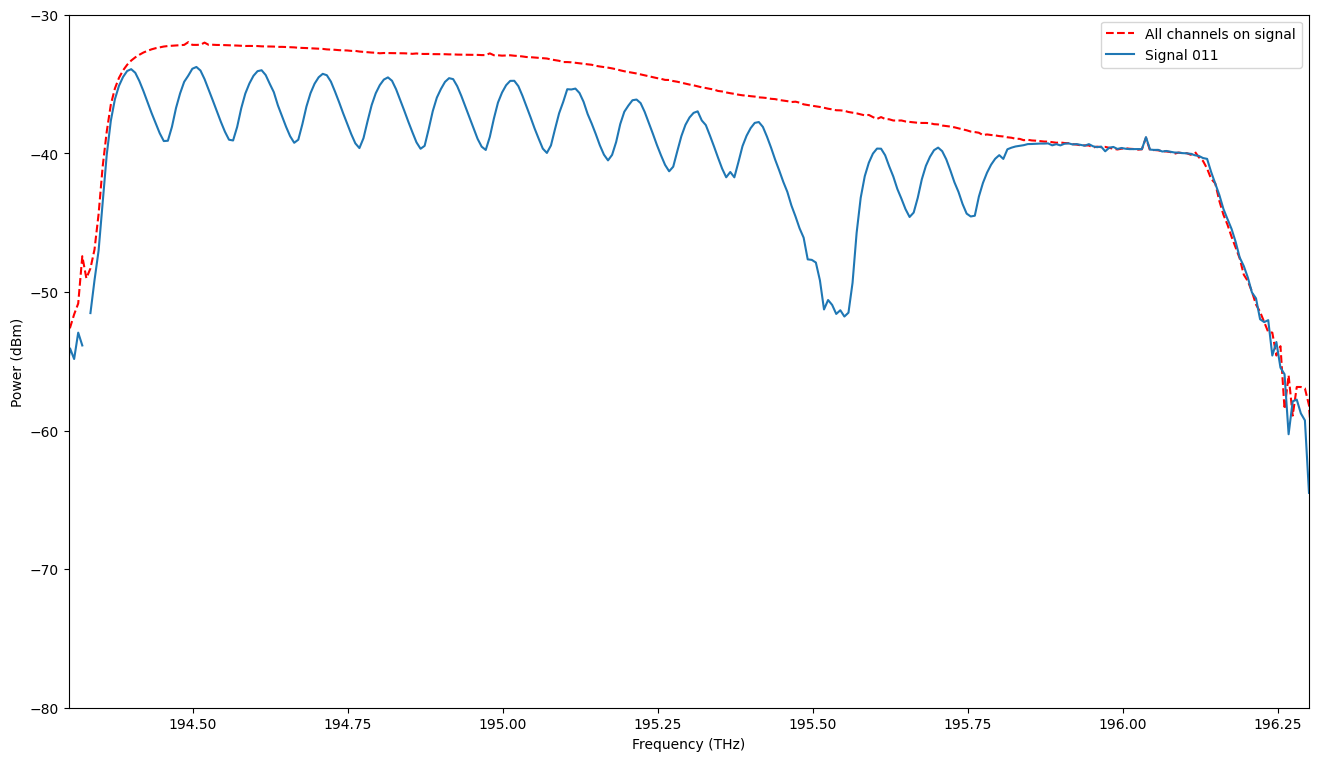

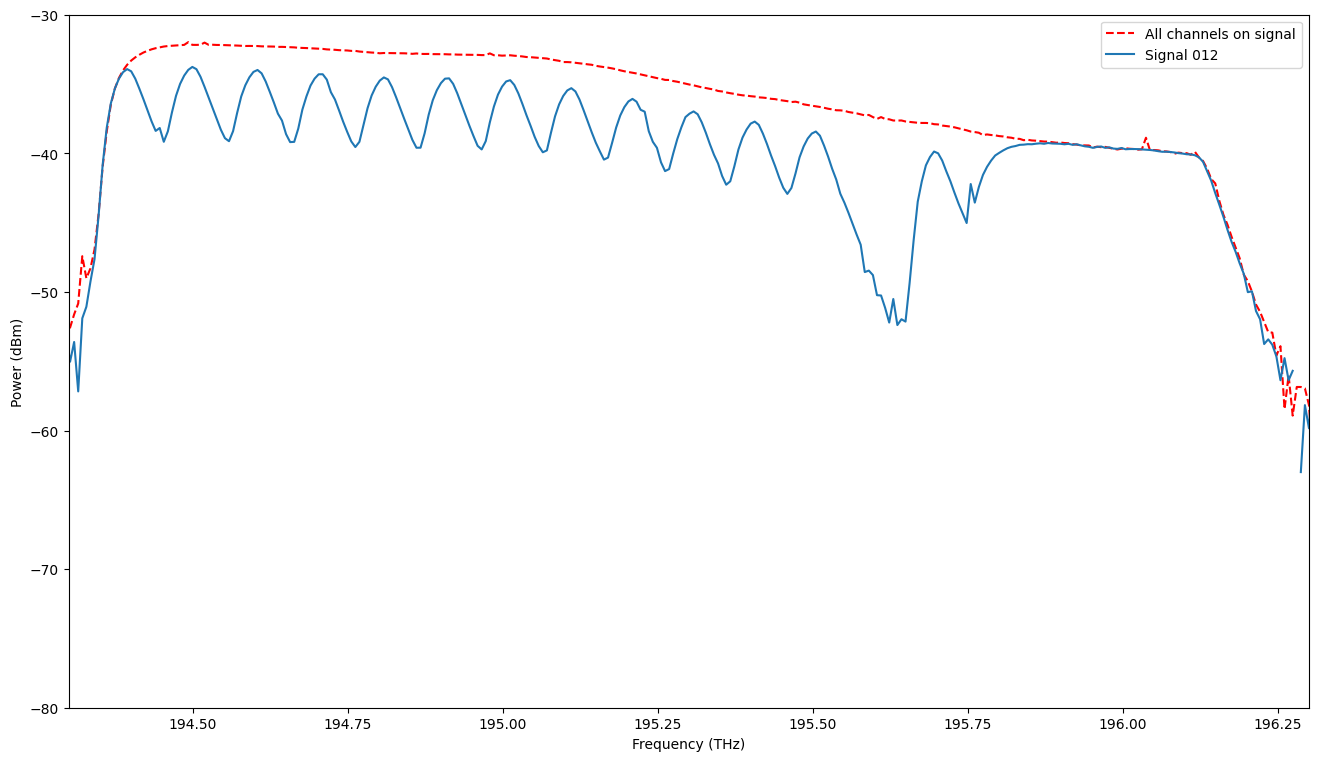

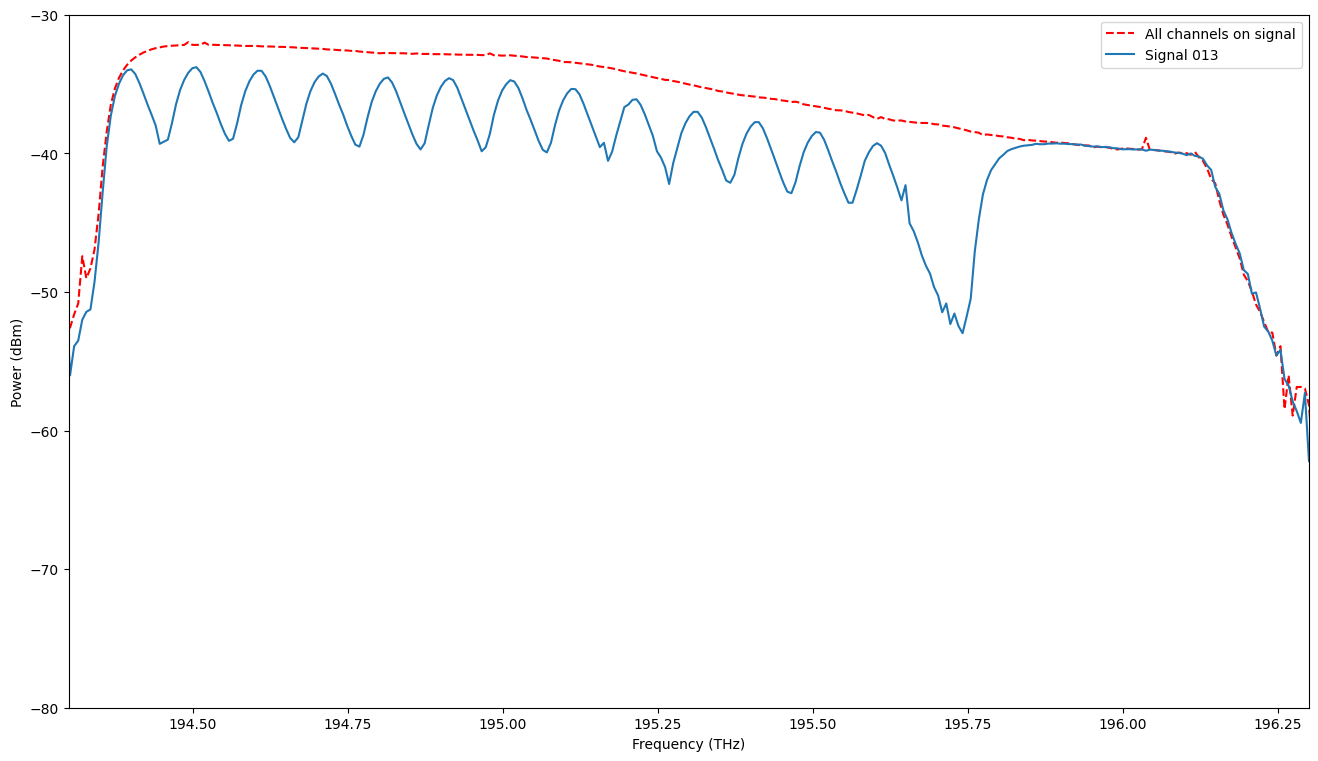

In [7]:
freqs = []
signals = []
for i in range(0, 14):
    # import the data from the text file
    t, signal = np.loadtxt(f'Data/channel_sim_off_onebyone/reading_{i:03}.txt', delimiter=',', skiprows=1).T
    # fix data by only taking first second of it (as it is periodic with 1s), total data is 2s long so half it
    t = t[:len(t)//2]
    signal = signal[:len(signal)//2]
    
    # fix the signal so it is in the center
    # do this by matching the on signal window with the signal
    # but must roll by the marker_81 value to make sure we index properly
    fixed_signal = V_to_dBm(np.roll(get_match_window(t, signal, marker_window), marker_81))
    signals.append(fixed_signal)
    
    # now convert time to frequency
    freq = s_to_THz(t)
    freqs.append(freq)

    # PLOTTING
    fig, ax = plt.subplots(
        1, 1,
        figsize=(16, 9)
    )

    # Plot the fixed signal with the on signal
    ax.plot(freq, V_to_dBm(signal_on), label=f'All channels on signal', color='r', ls='--', zorder=0)
    ax.plot(freq, fixed_signal, label=f'Signal {i:03}', zorder=1)
    
    ax.legend()
    
    ax.set_xlim(194.3, 196.3)
    ax.set_ylim(-80, -30)
        
    ax.set_ylabel('Power (dBm)')
    ax.set_xlabel('Frequency (THz)')

freqs = np.array(freqs)
signals = np.array(signals)

Let's compare `signal_000` of `Data/channel_sim_off_onebyone/` (channels) to `signal_001` of `Data/channel_sim_off_onebyone/` (channel 54 is turned off):

Text(0.5, 0, 'Frequency (THz)')

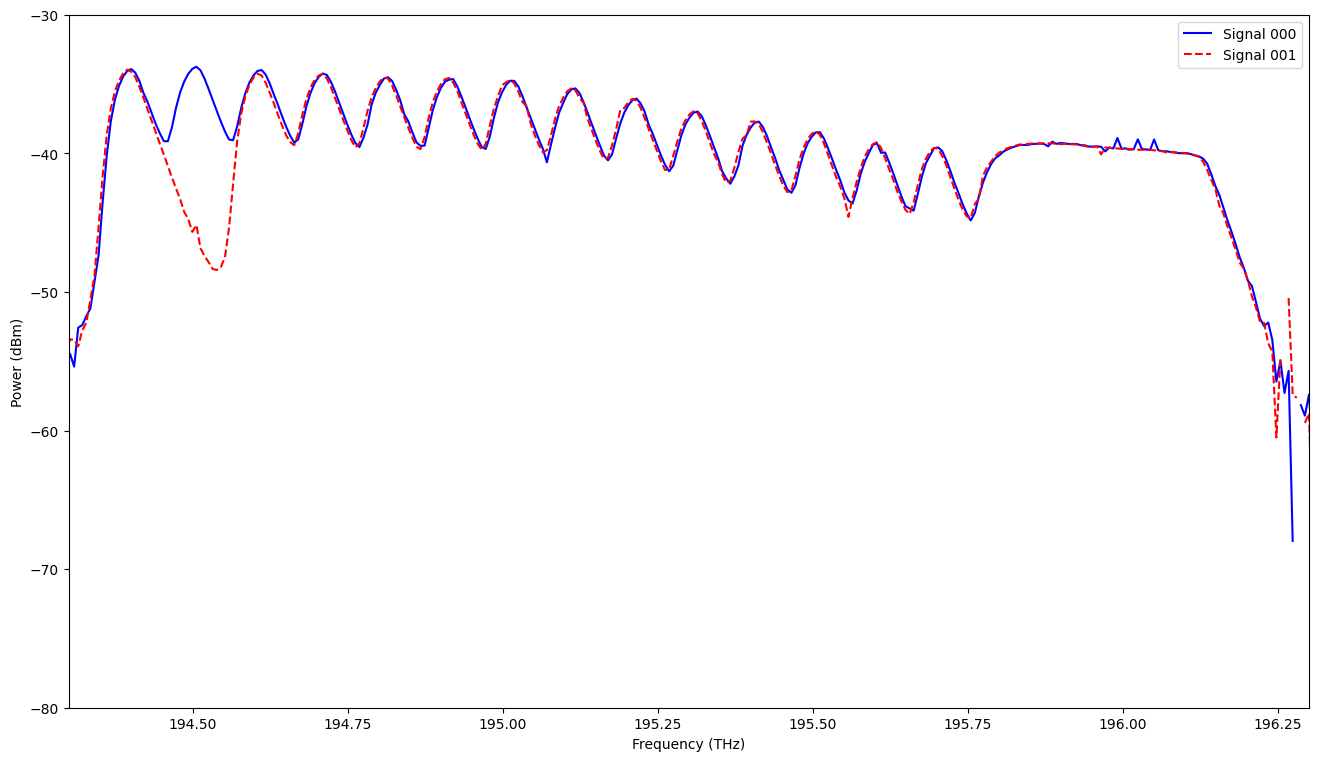

In [8]:
# PLOTTING
fig, ax = plt.subplots(
    1, 1,
    figsize=(16, 9)
)

# Plot the fixed signal with the on signal
ax.plot(freqs[0], signals[0], color='b', ls='-', label=f'Signal 000', zorder=1)
ax.plot(freqs[1], signals[1], color='r', ls='--', label=f'Signal 001', zorder=2)

ax.legend()

ax.set_xlim(194.3, 196.3)
ax.set_ylim(-80, -30)

ax.set_ylabel('Power (dBm)')
ax.set_xlabel('Frequency (THz)')

We can also filter each signal using a Savitzky-Golay filter.

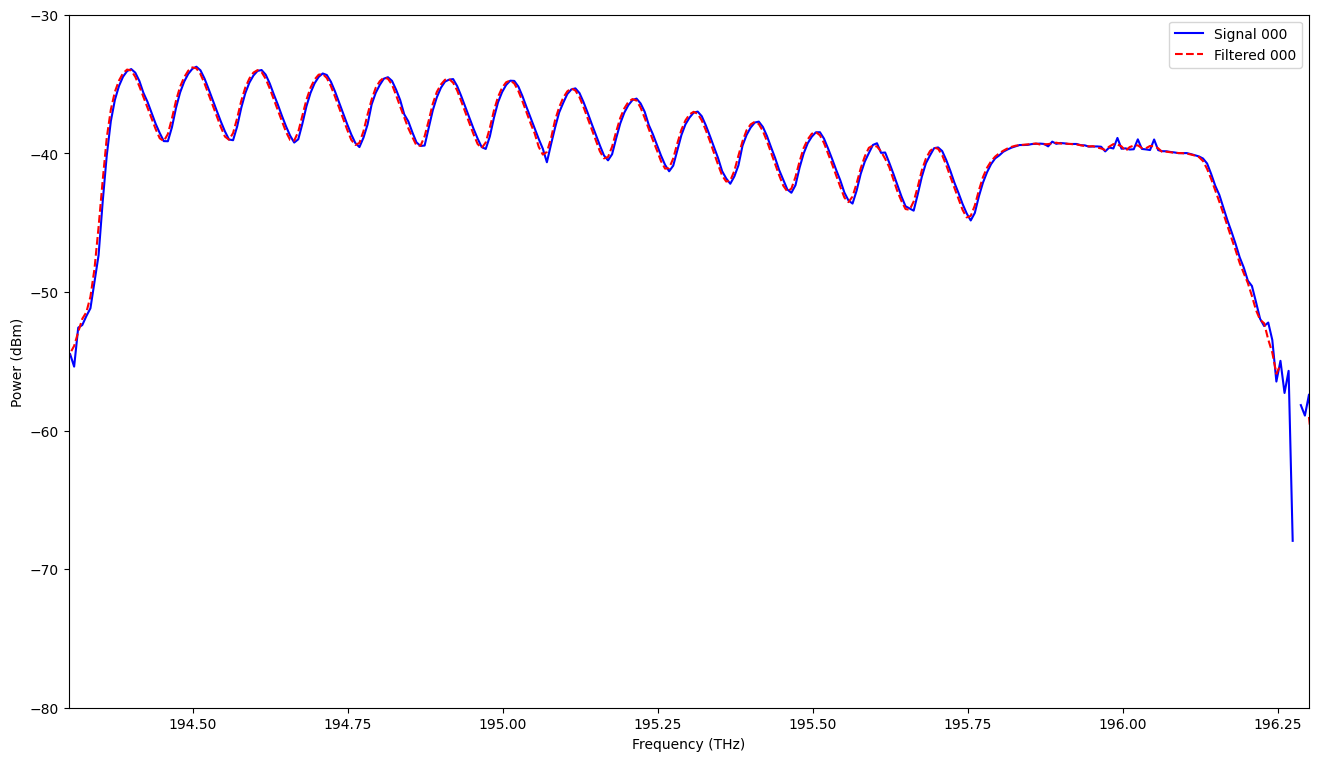

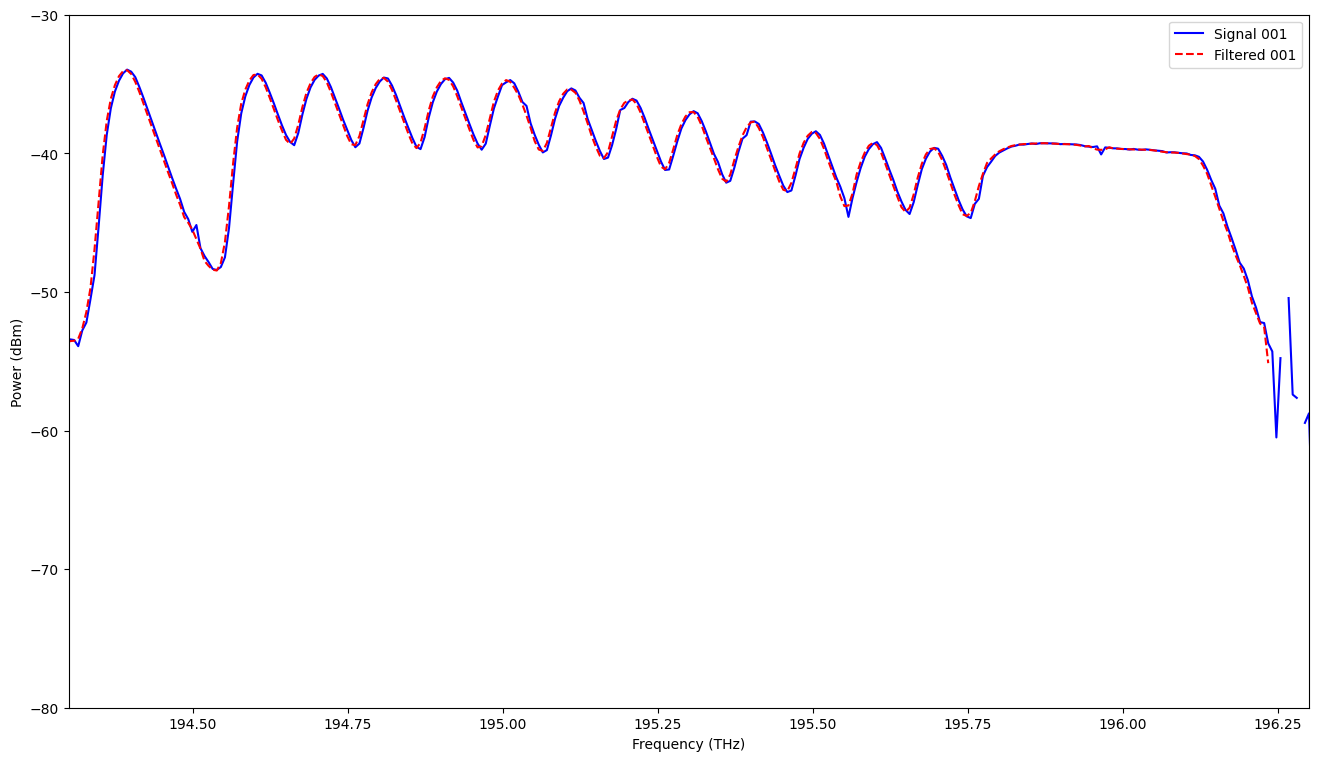

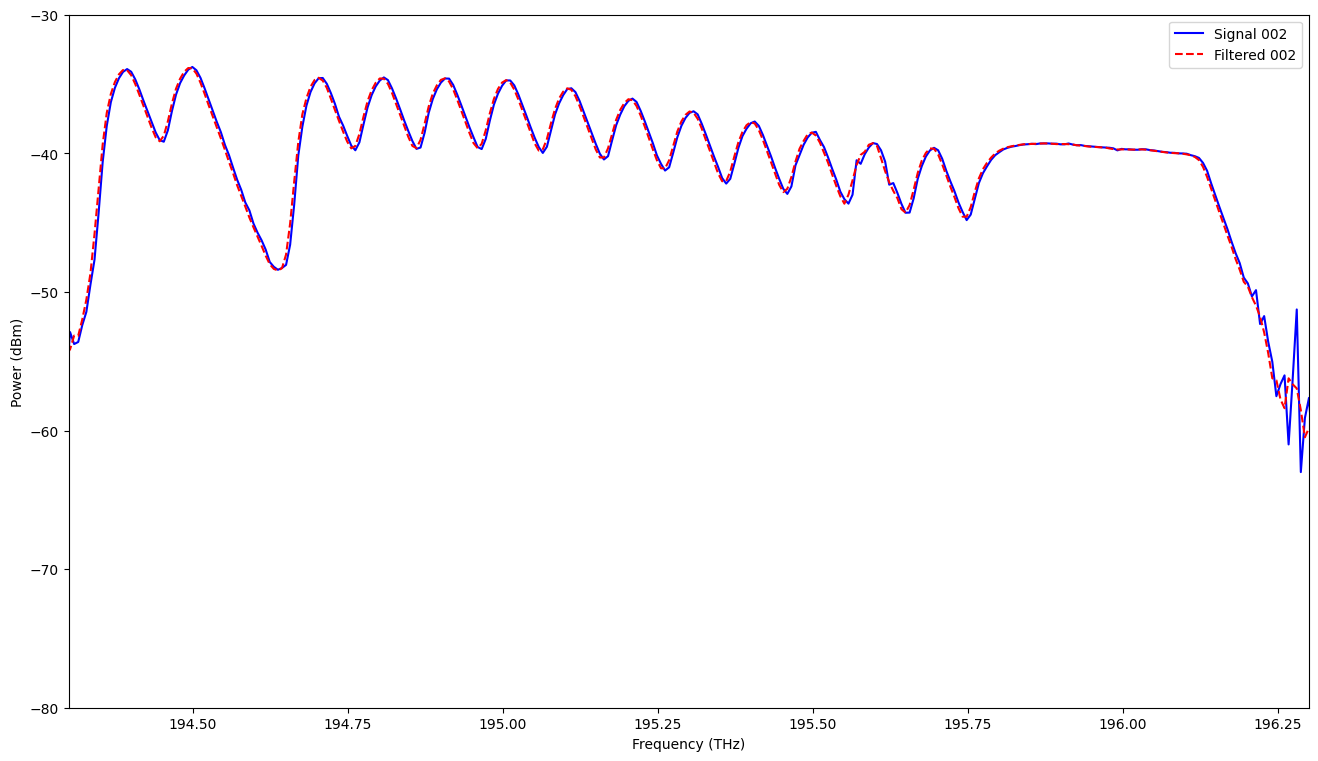

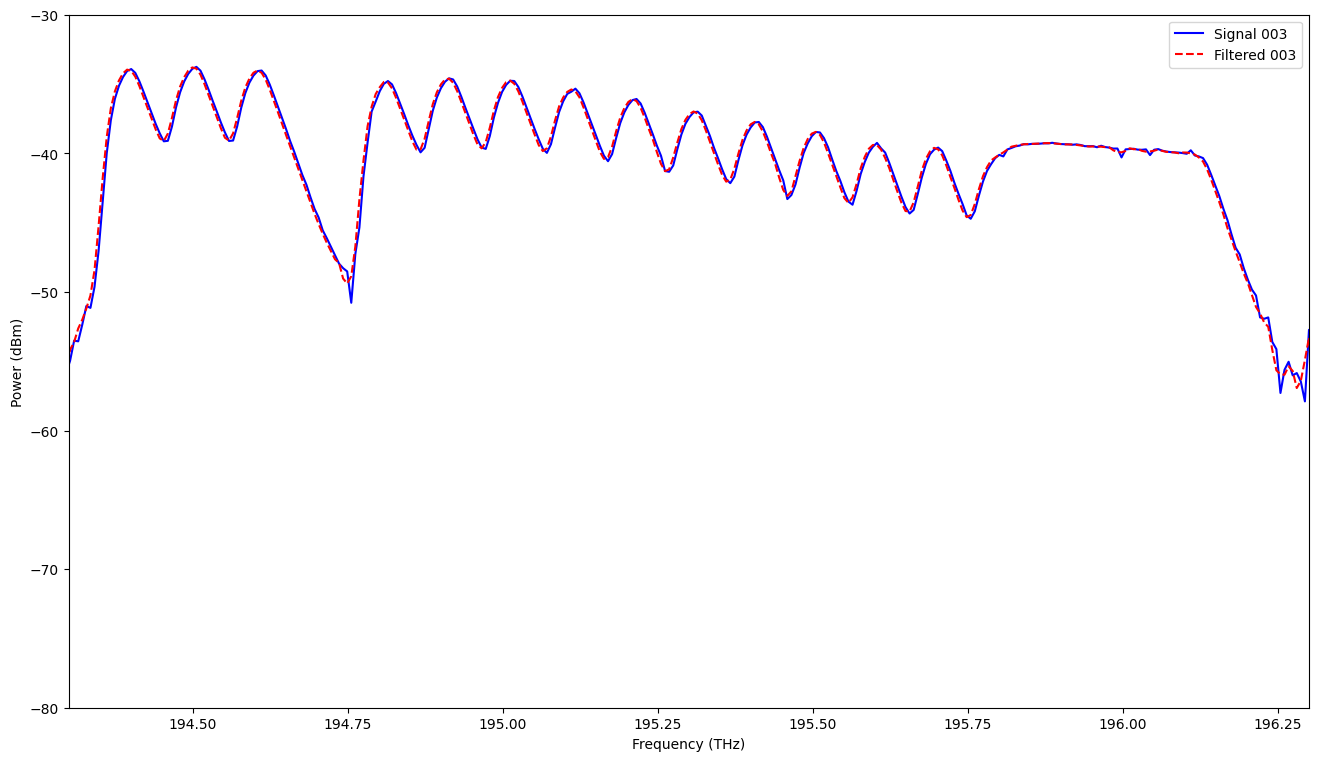

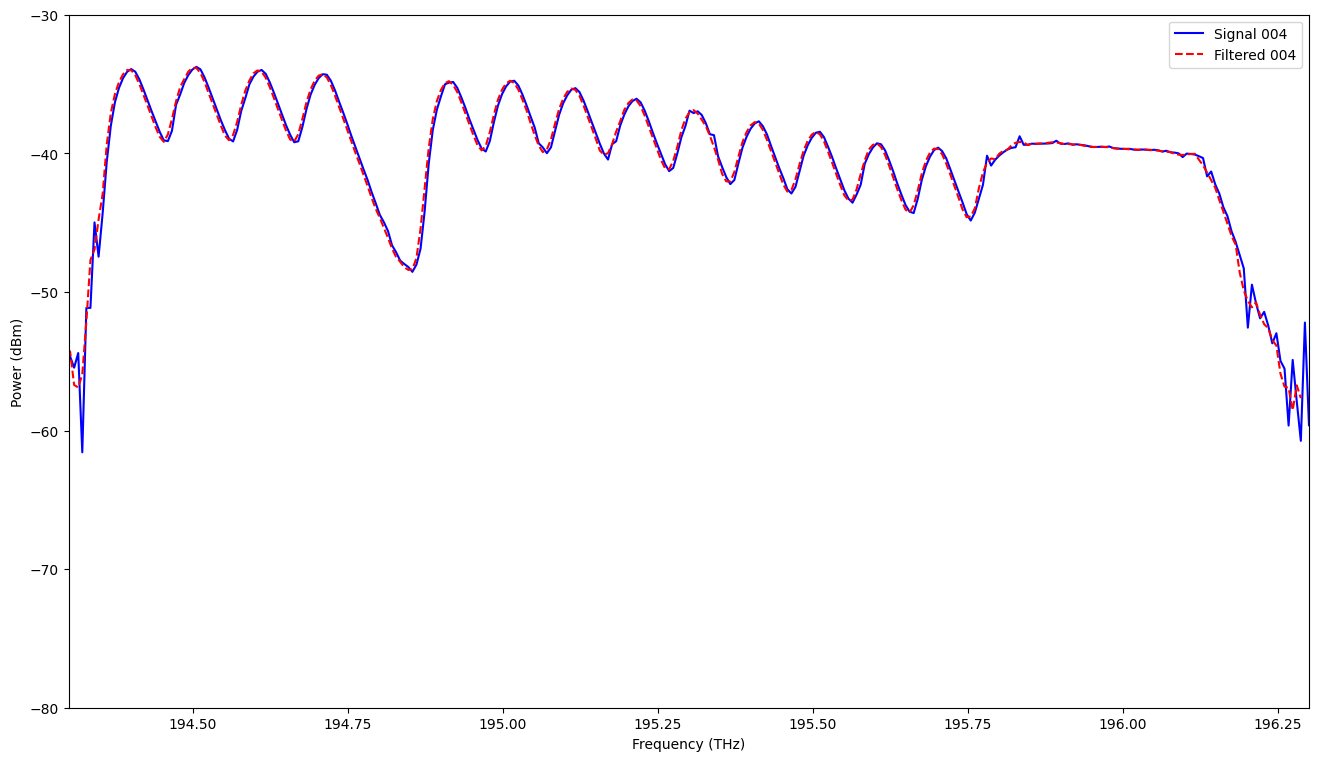

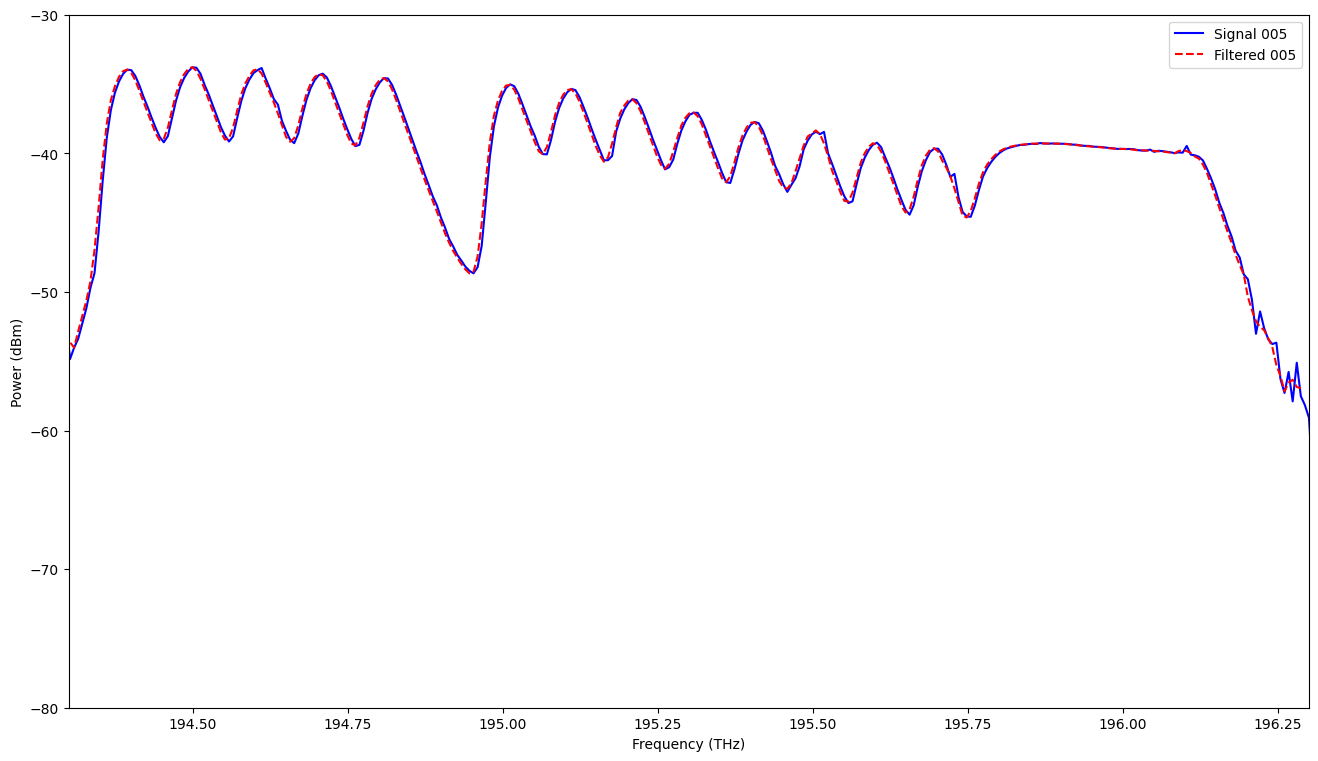

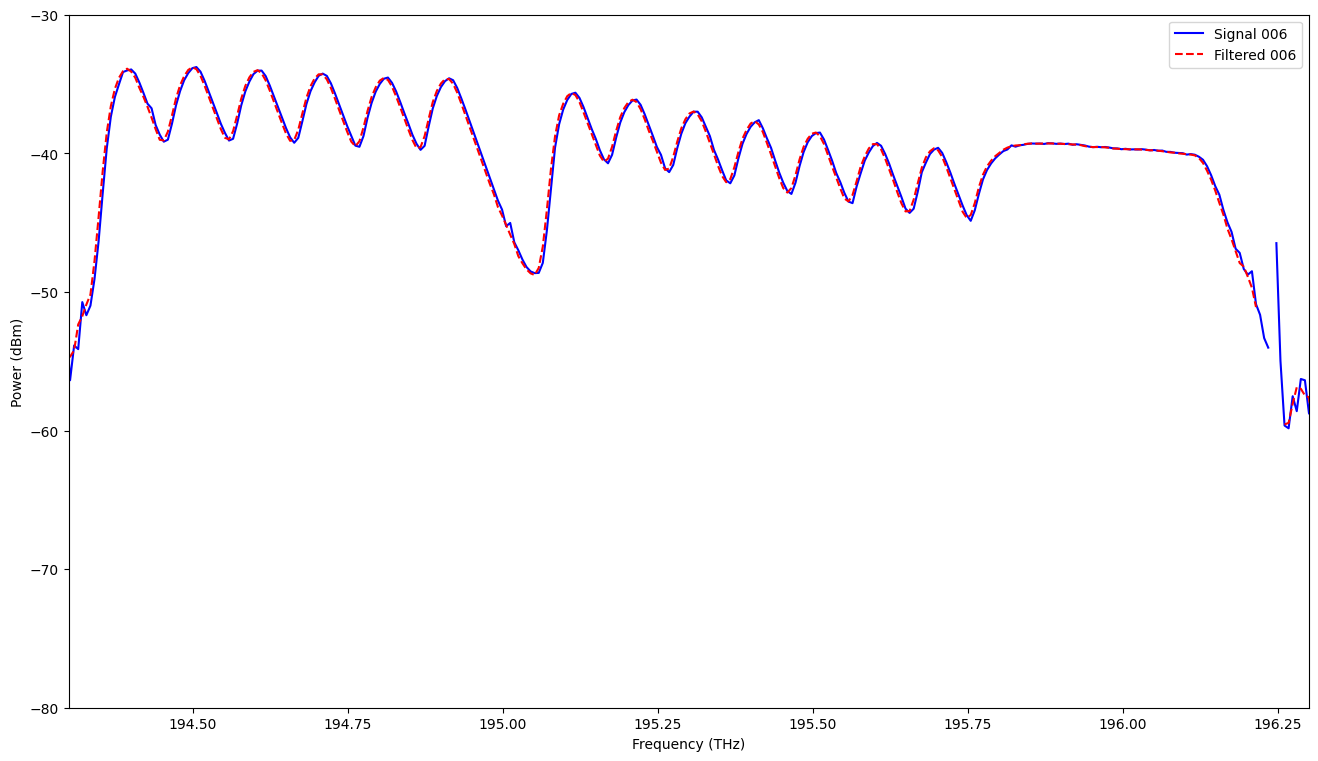

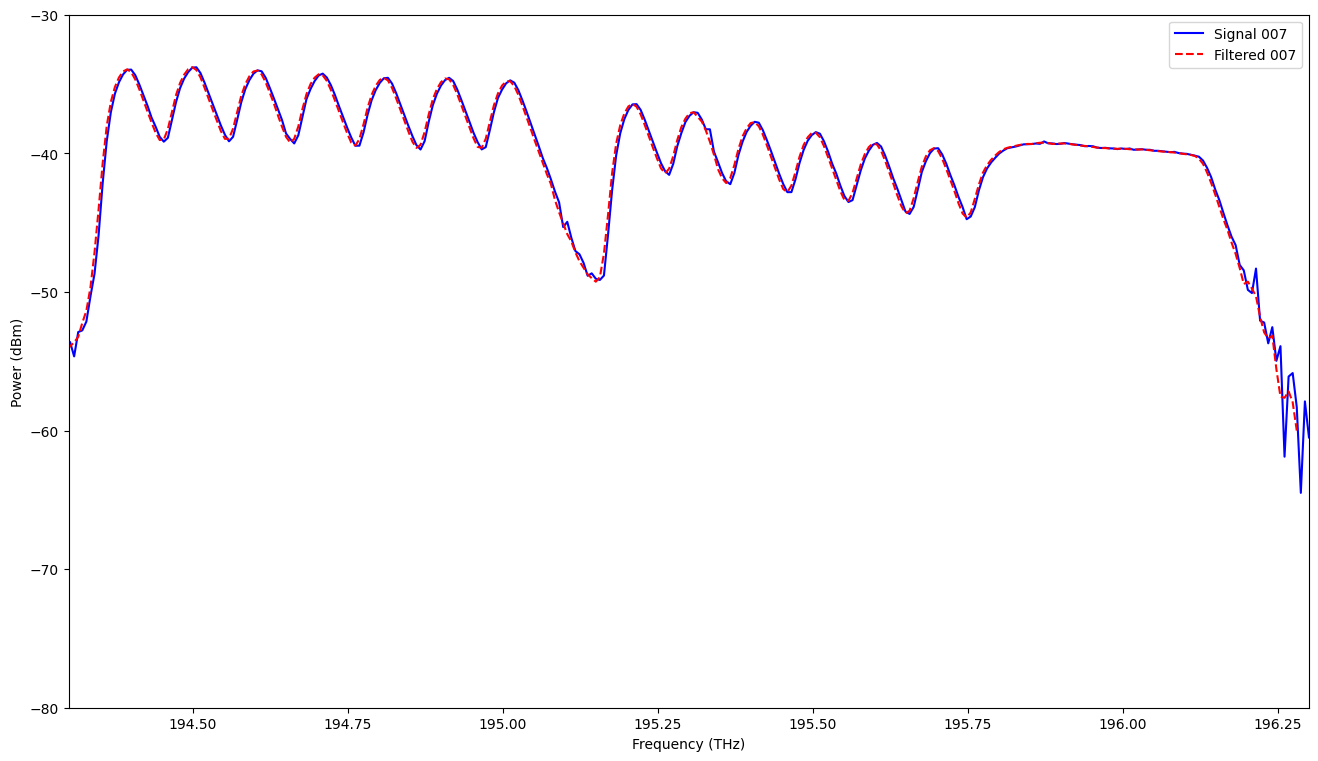

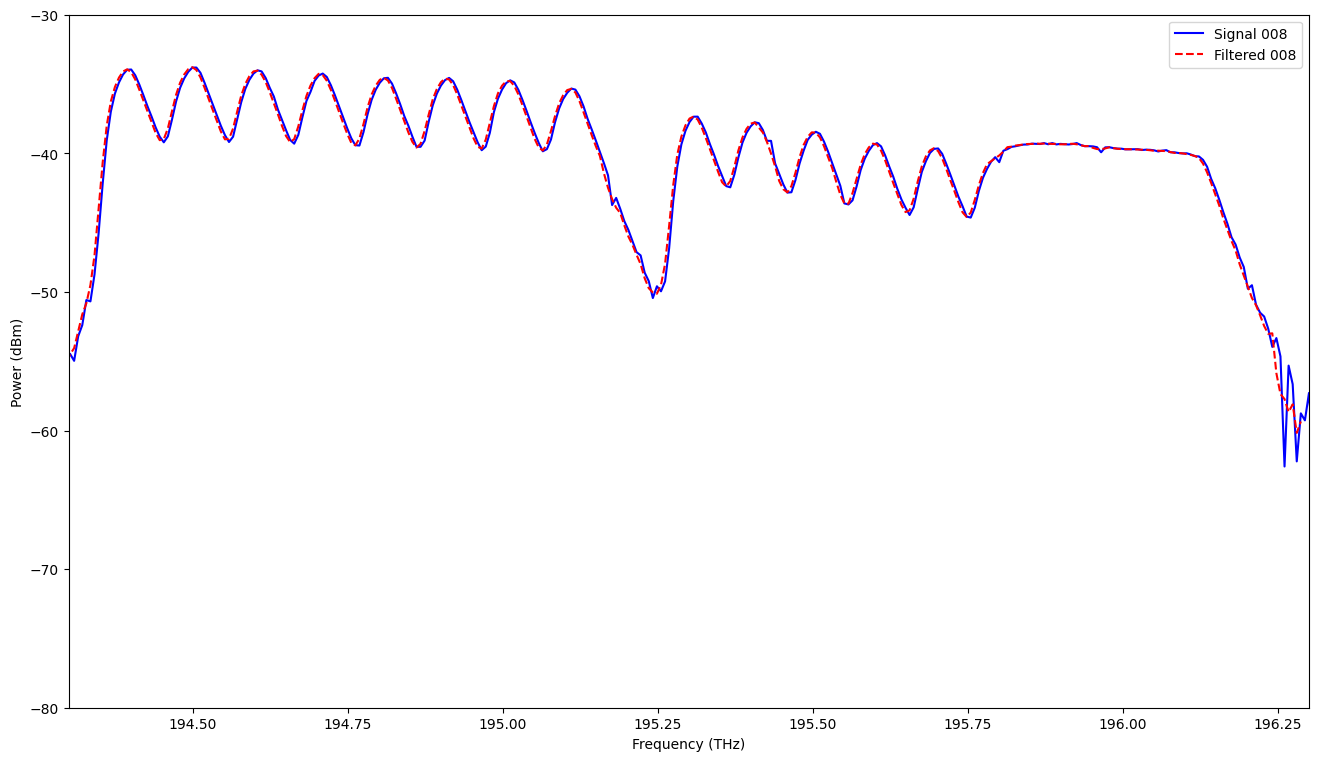

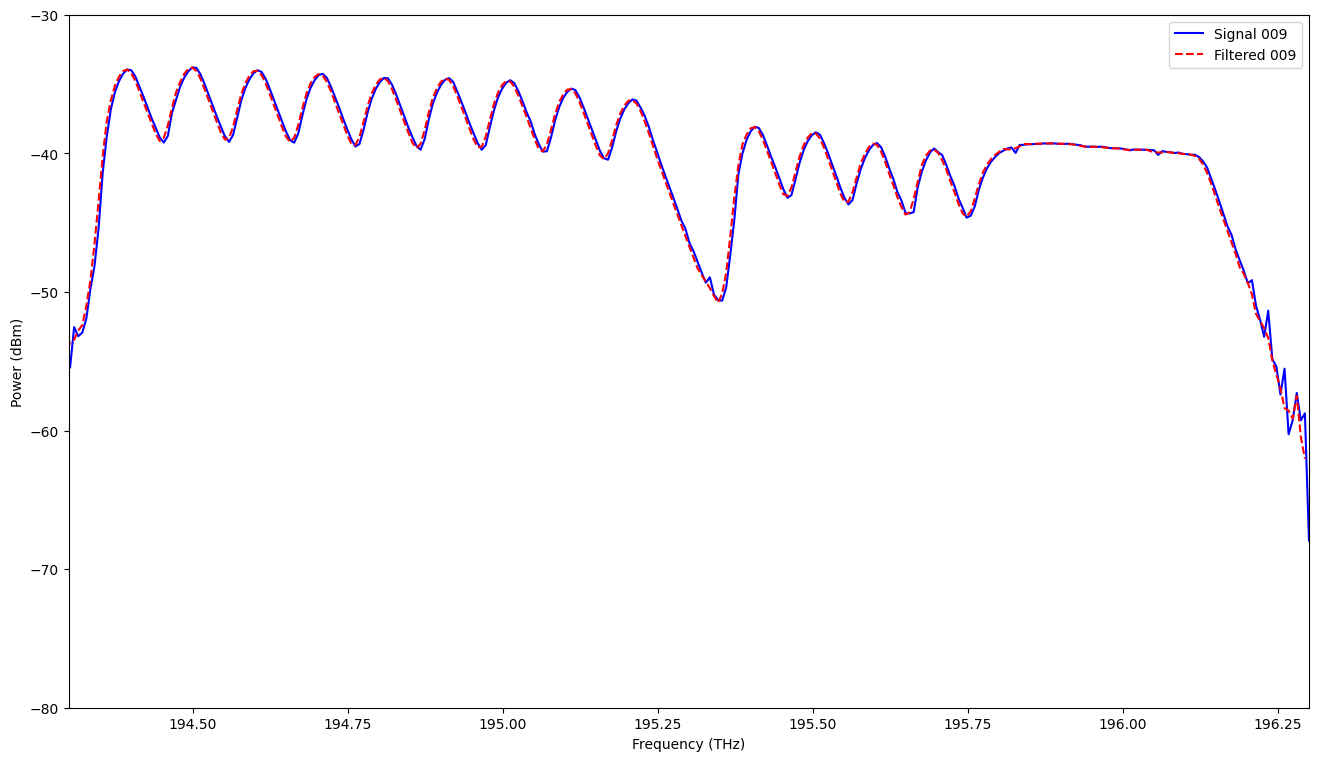

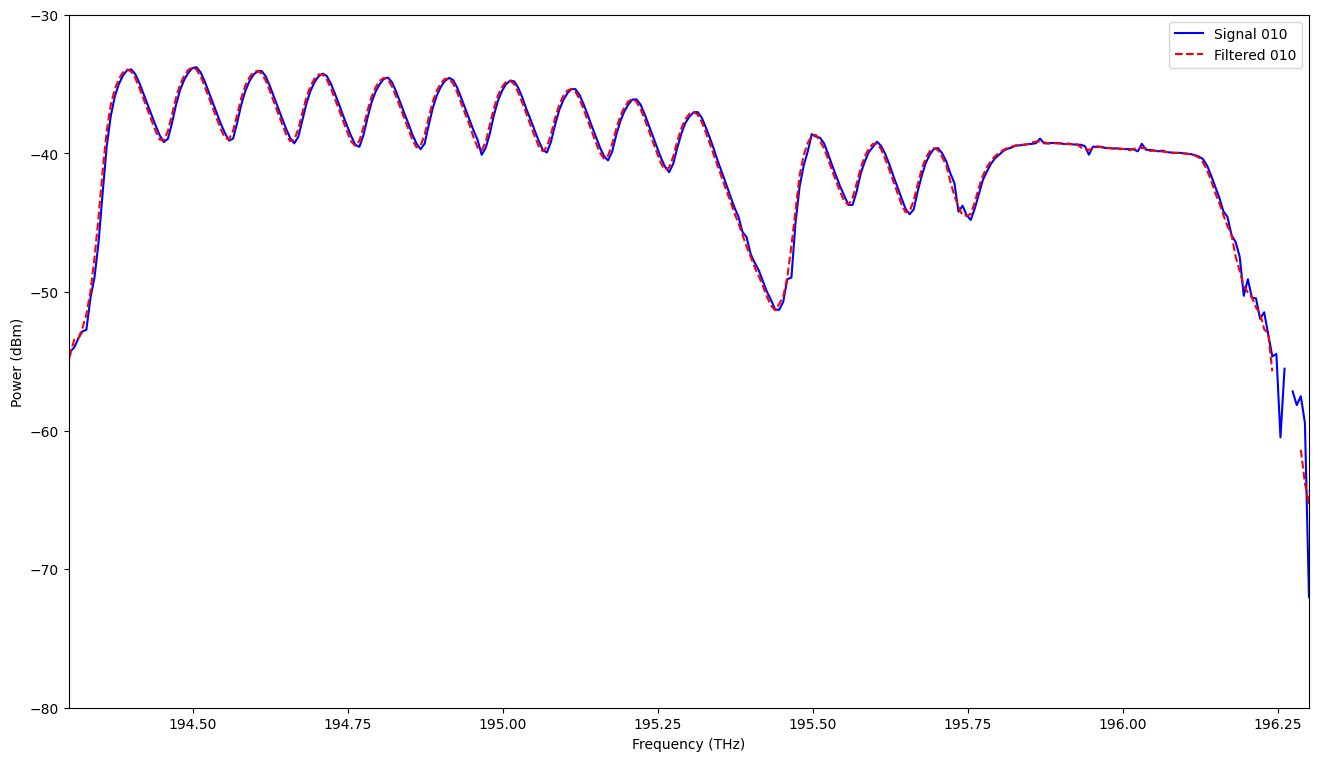

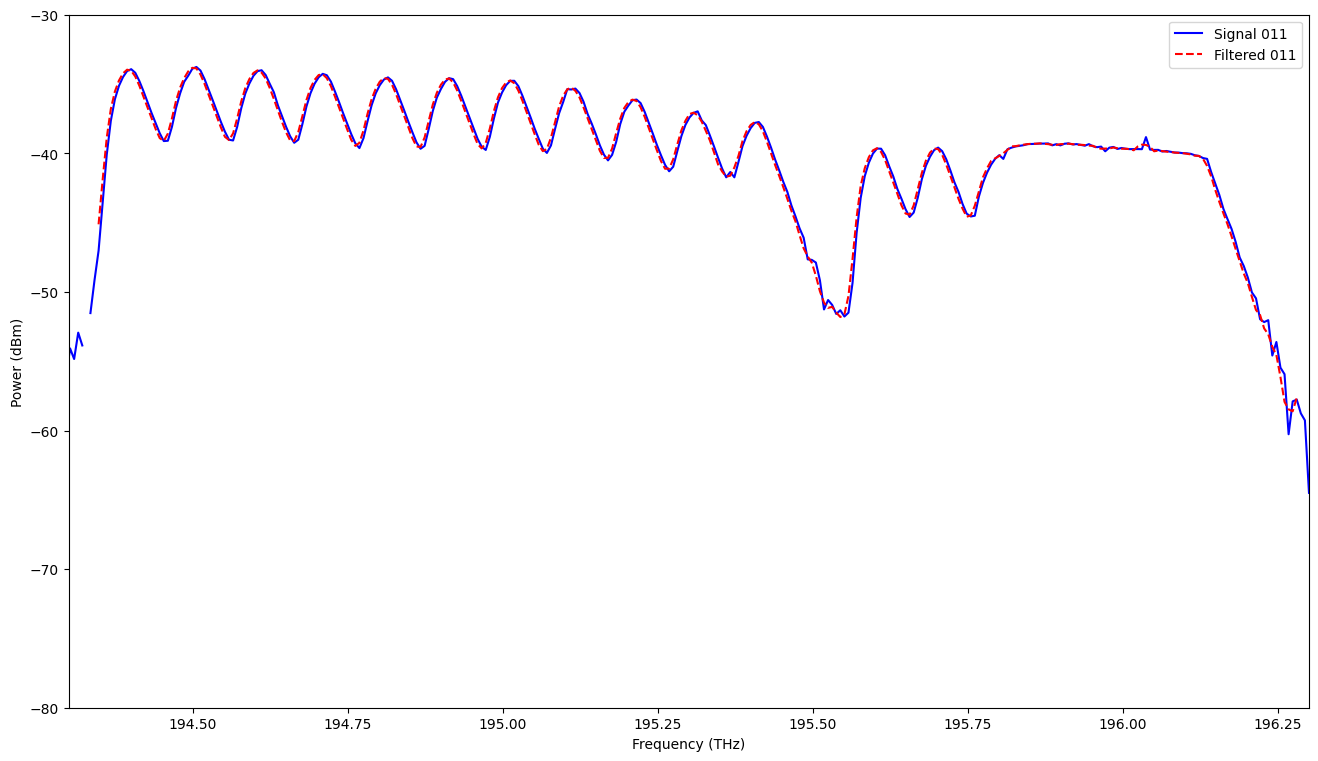

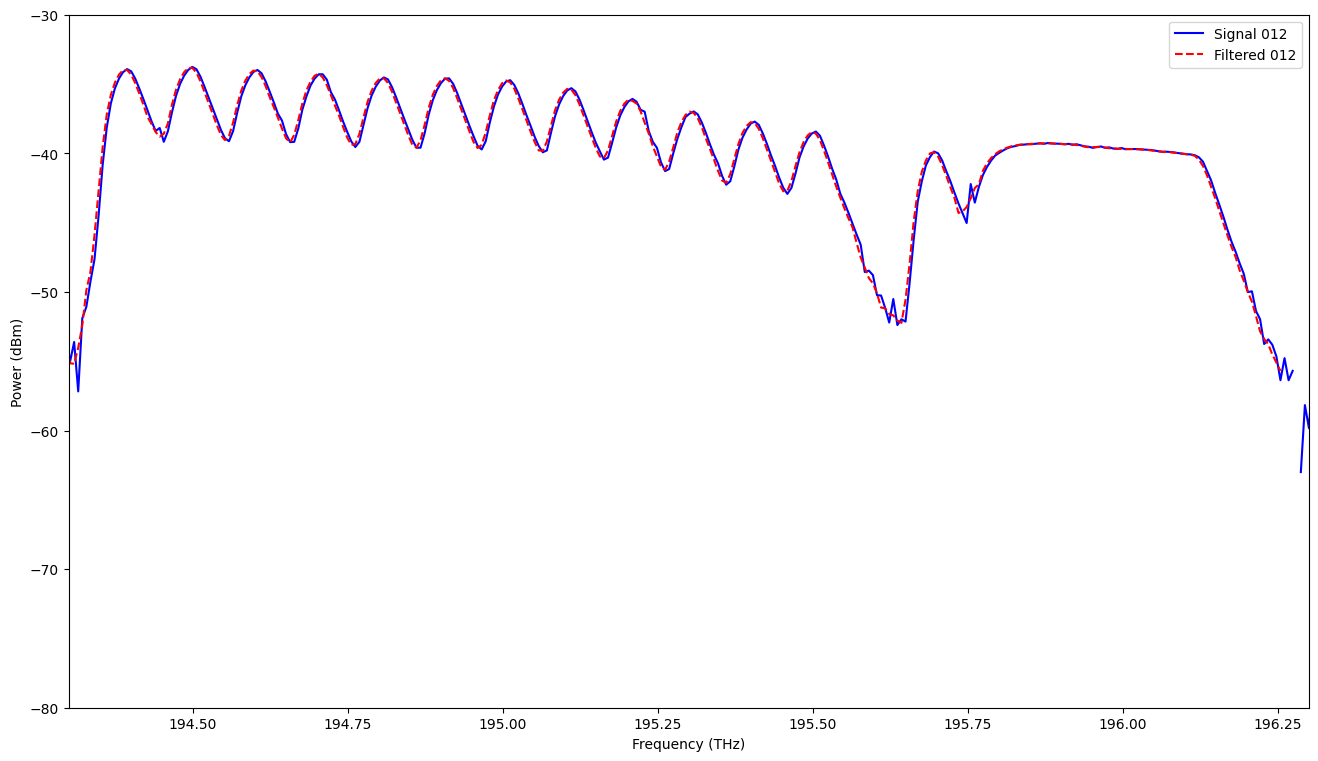

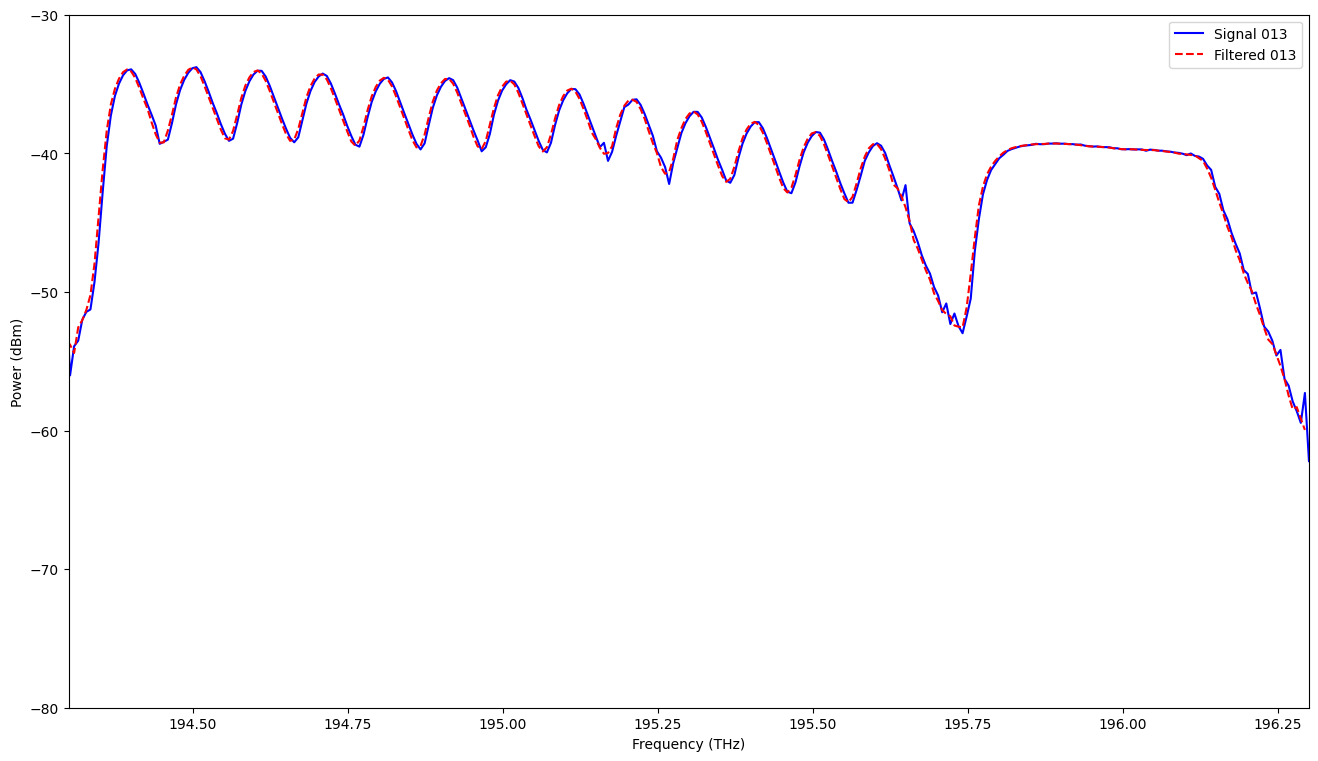

In [9]:
for i in range(len(signals)):
    # filter this signal
    filtered_signal = savgol_filter(signals[i], 6, 3) # window size 6, polynomial order 3

    # PLOTTING
    fig, ax = plt.subplots(
        1, 1,
        figsize=(16, 9)
    )

    # Plot the fixed signal with the on signal
    ax.plot(freqs[i], signals[i], color='b', ls='-', label=f'Signal {i:03}', zorder=1)
    ax.plot(freqs[i], filtered_signal, color='r', ls='--', label=f'Filtered {i:03}', zorder=2)

    ax.legend()

    ax.set_xlim(194.3, 196.3)
    ax.set_ylim(-80, -30)

    ax.set_ylabel('Power (dBm)')
    ax.set_xlabel('Frequency (THz)')

We can find the peaks and troughs, looking only in the relevant range:

*Note that only Signal 011 has multiple troughs where the channel is turned off.*

[-48.45693004 -48.45242167 -49.393525   -48.41365226 -48.65953089
 -48.7795347  -49.2620628  -50.12931782 -50.77512673 -51.32814485
 -51.14873752 -52.22992038 -52.55838543]


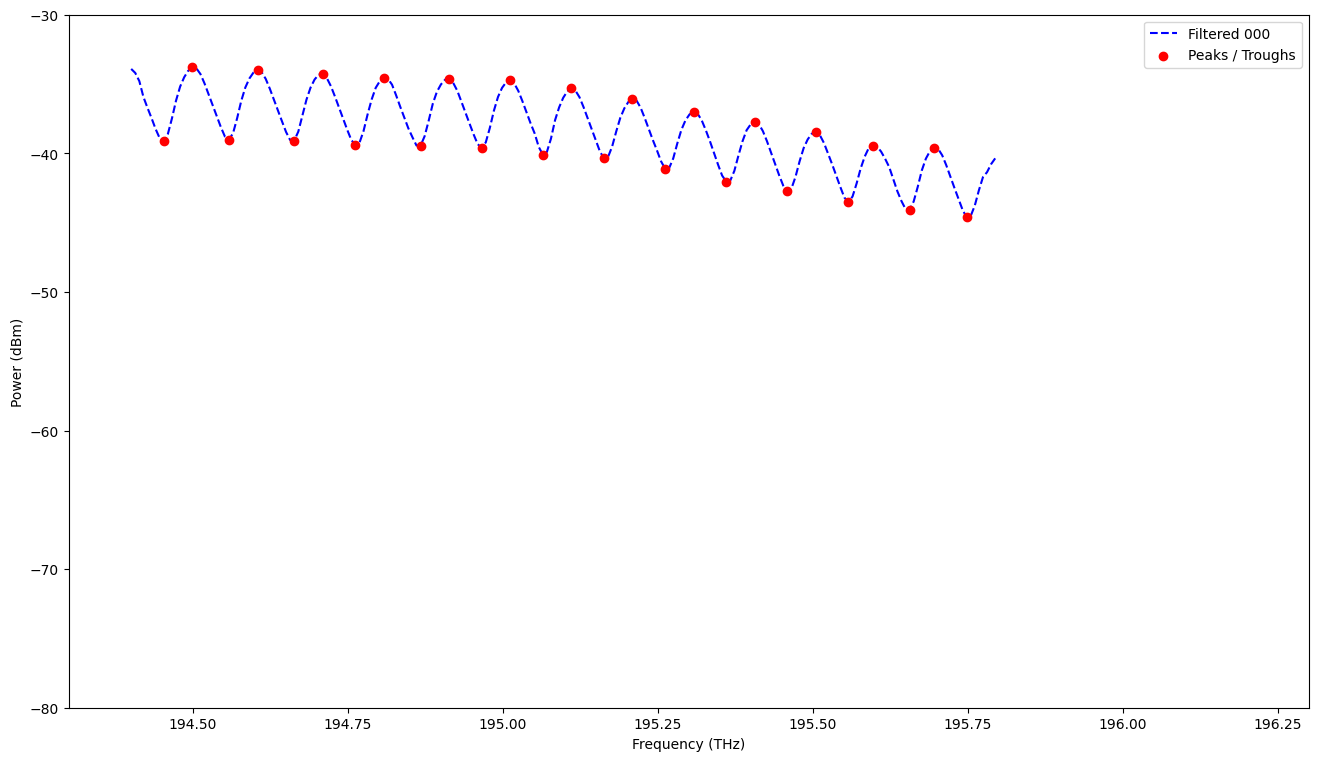

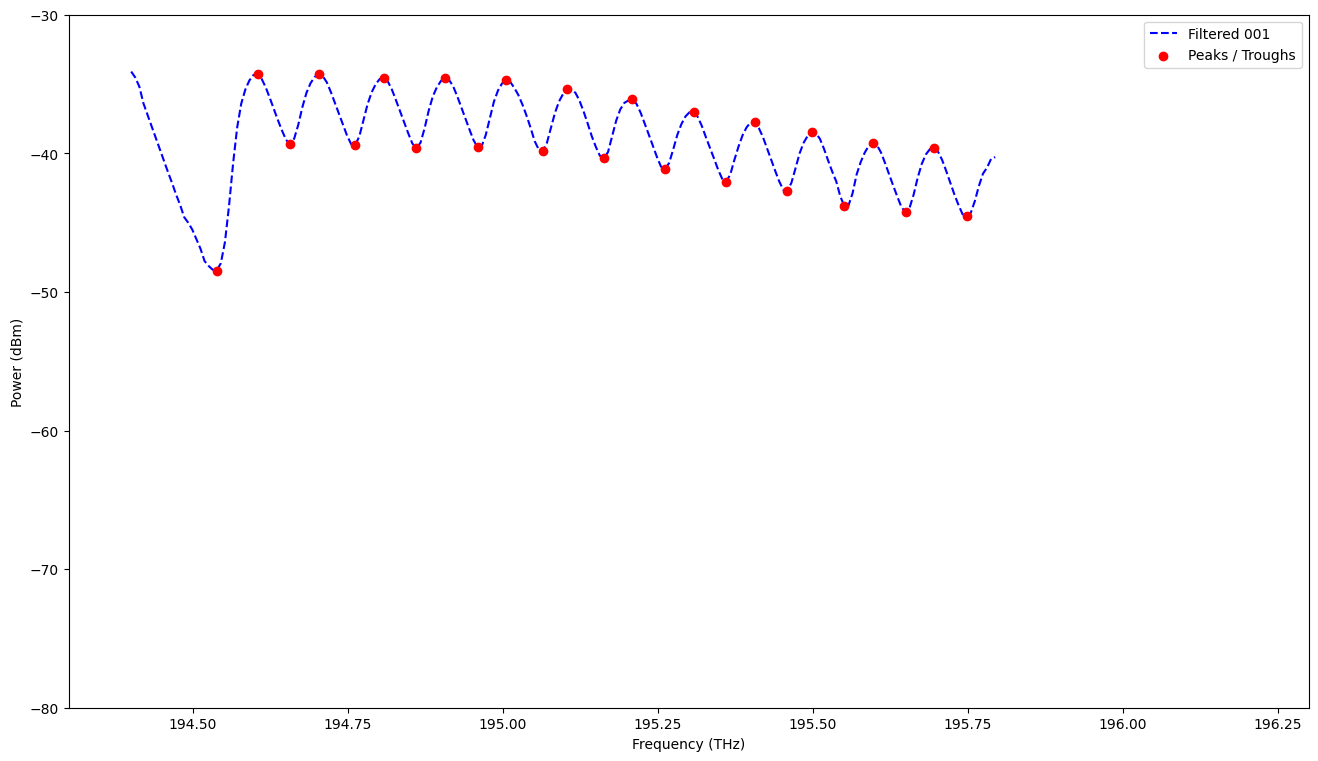

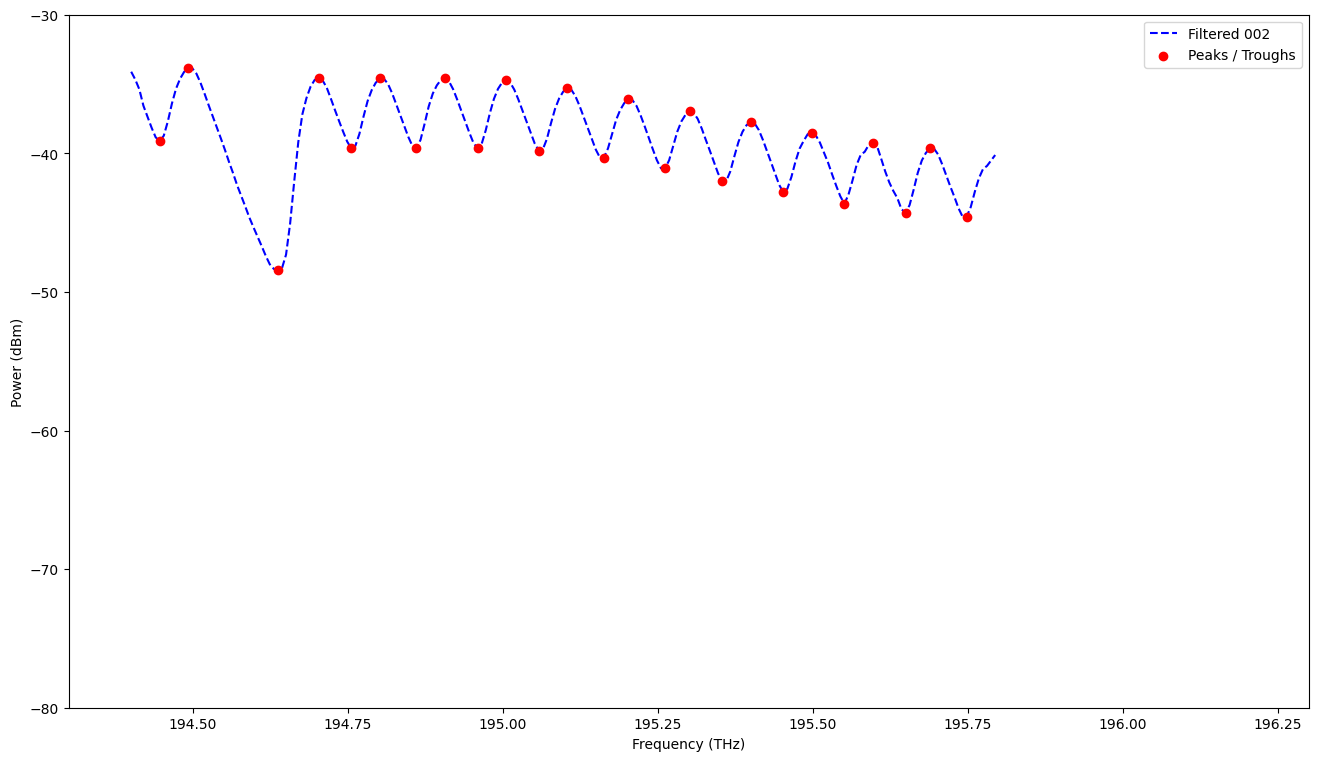

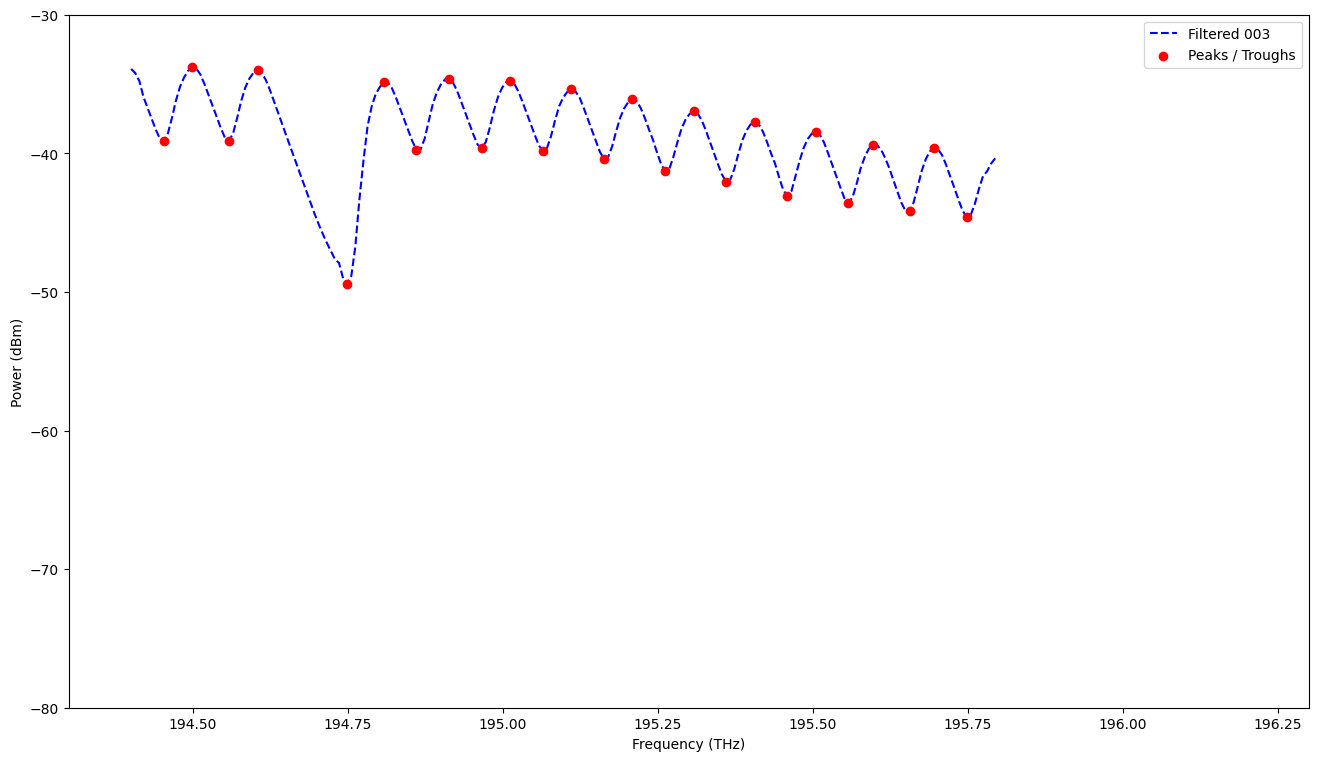

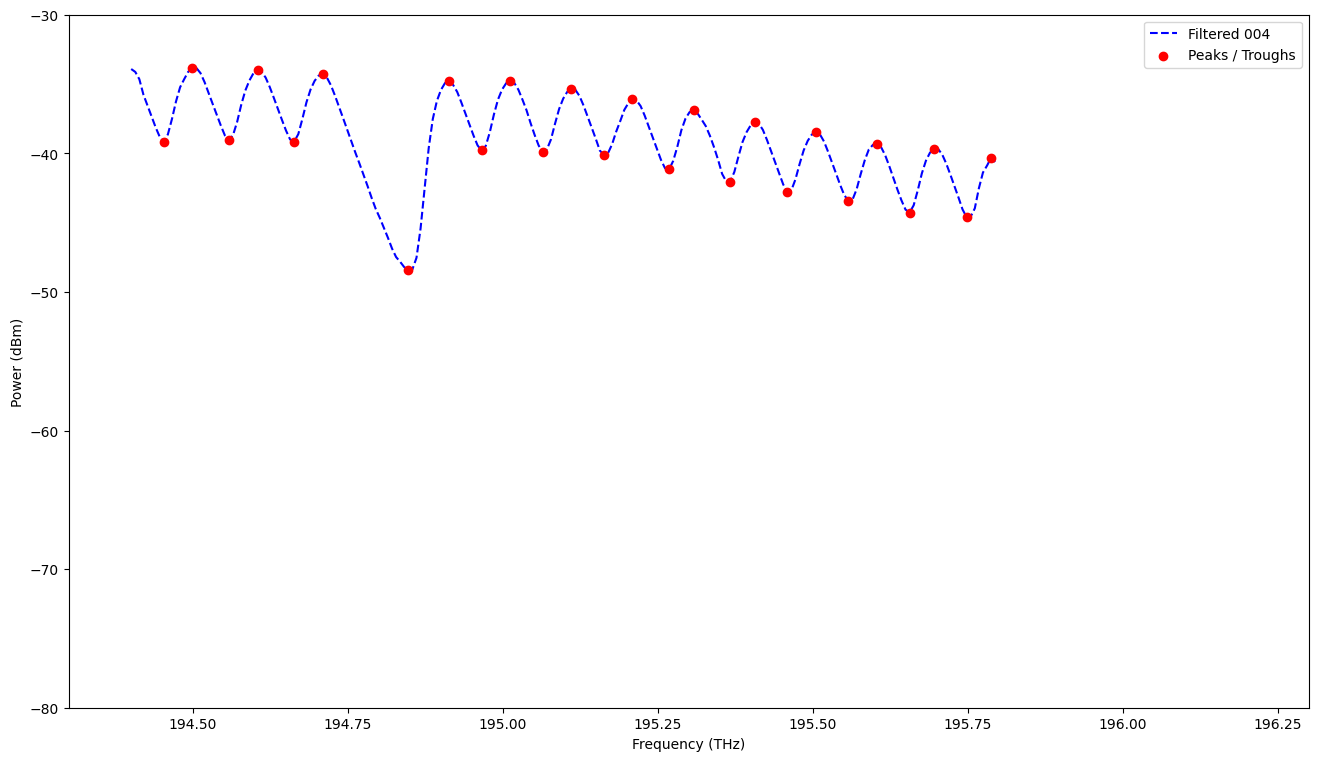

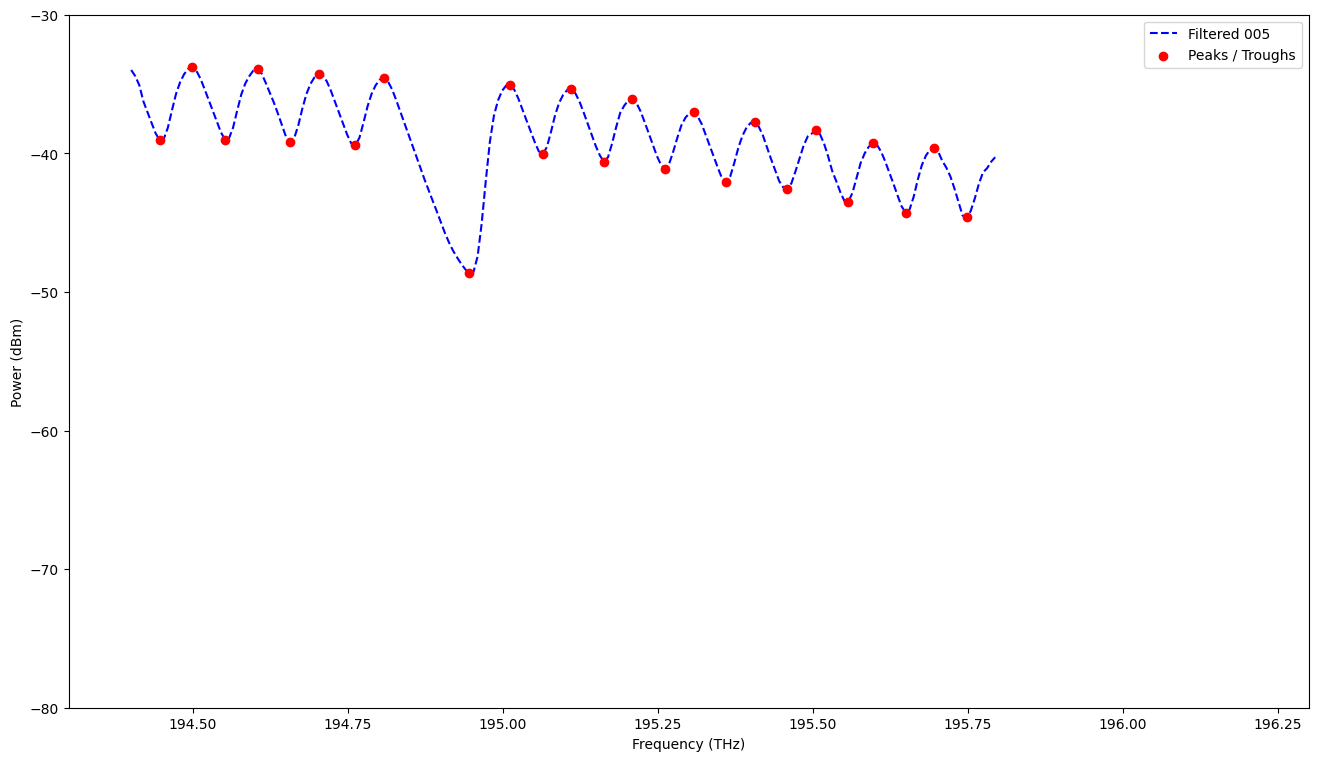

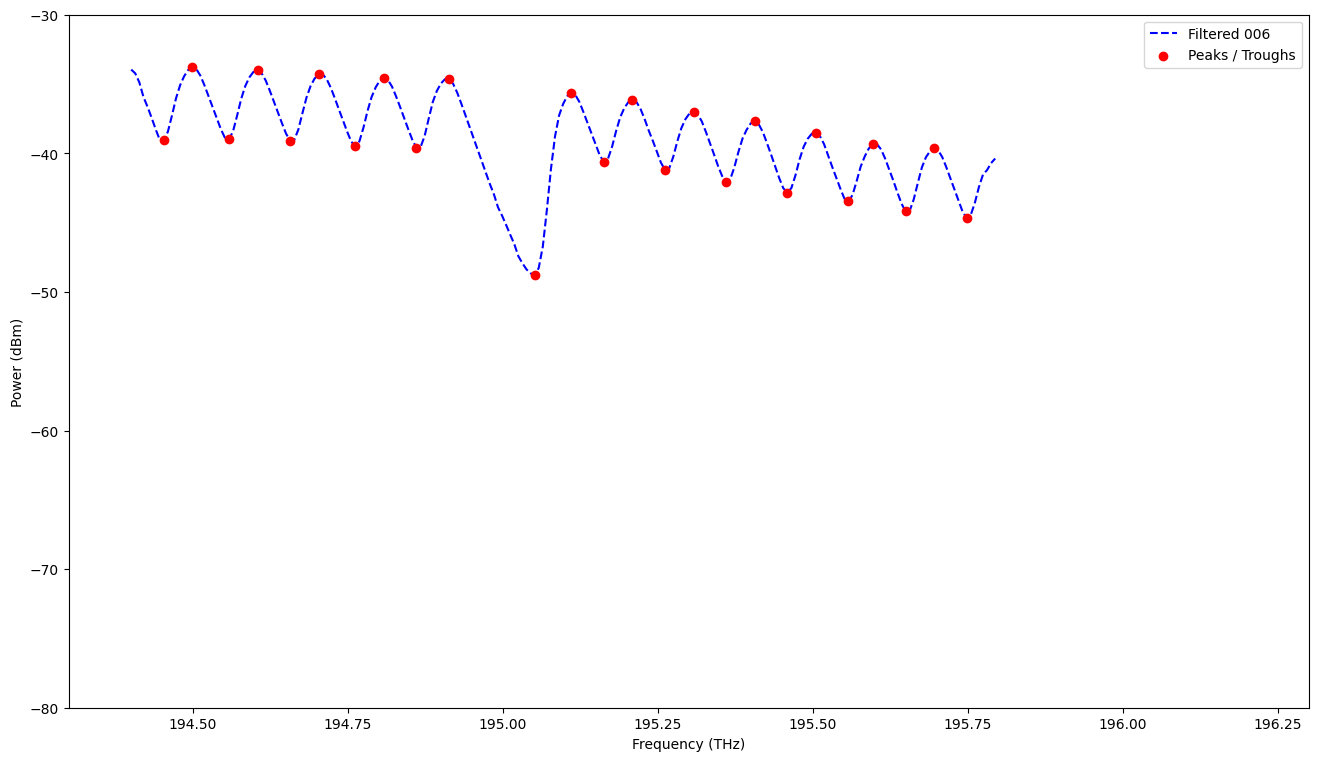

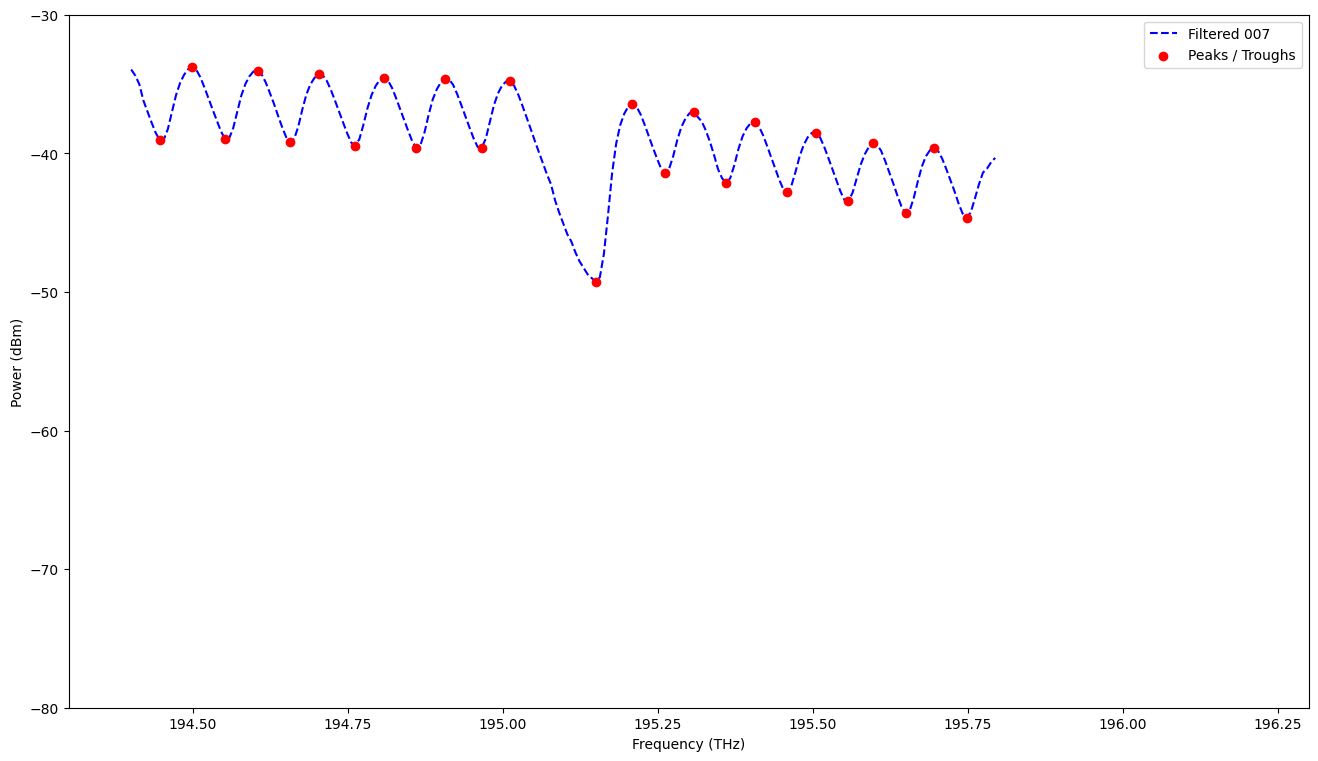

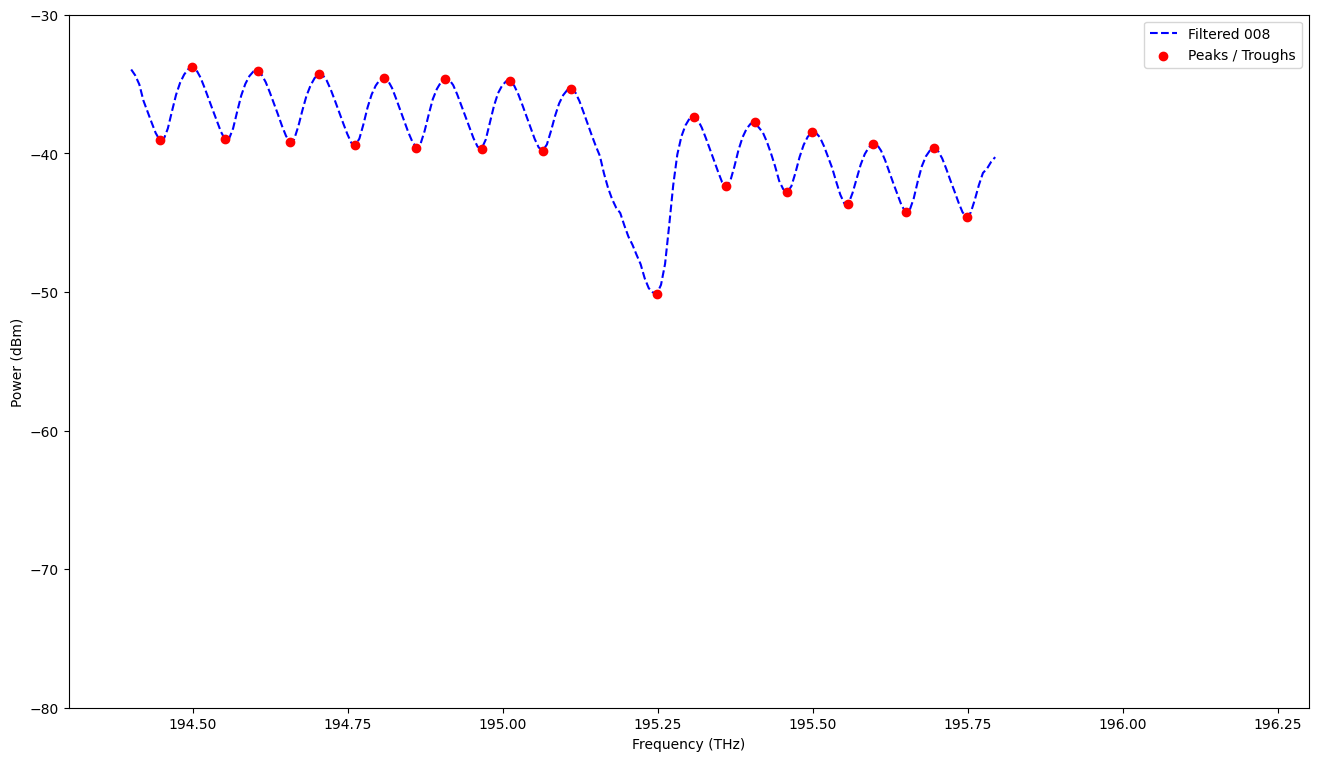

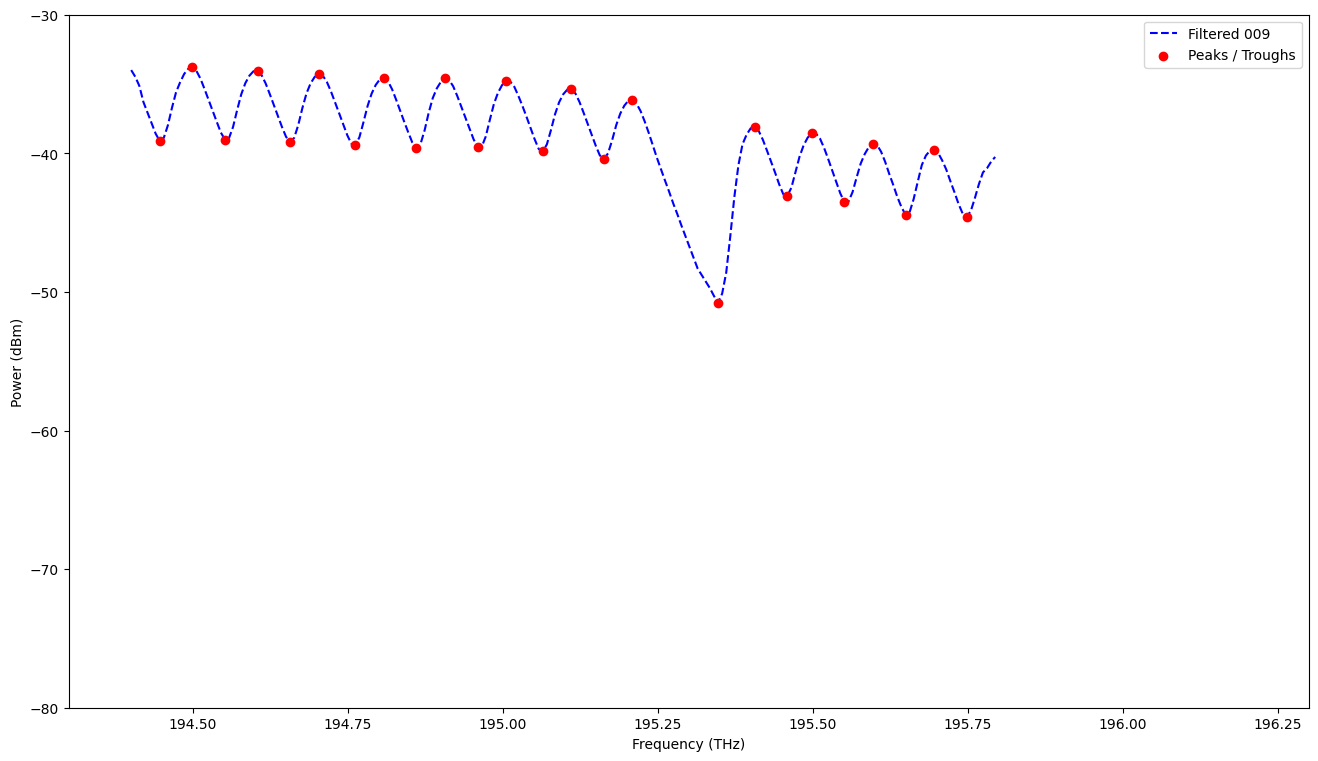

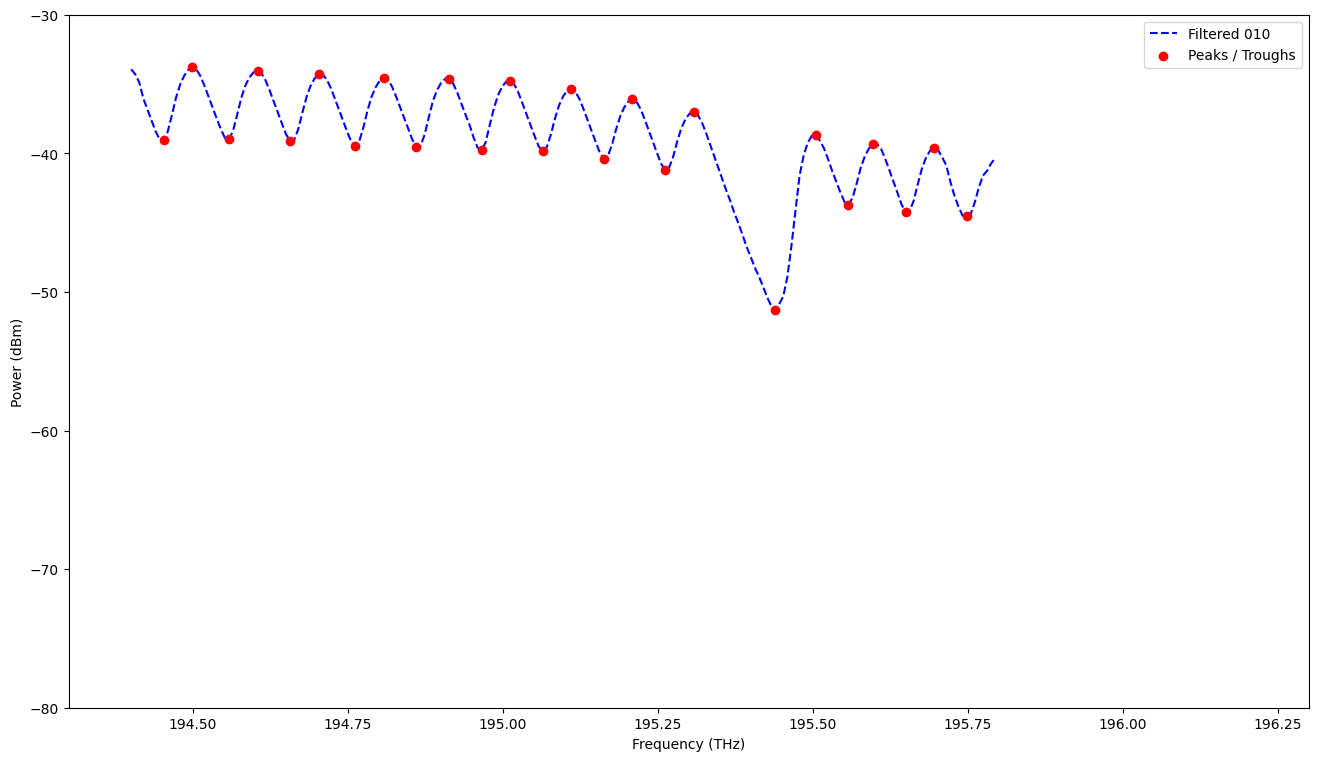

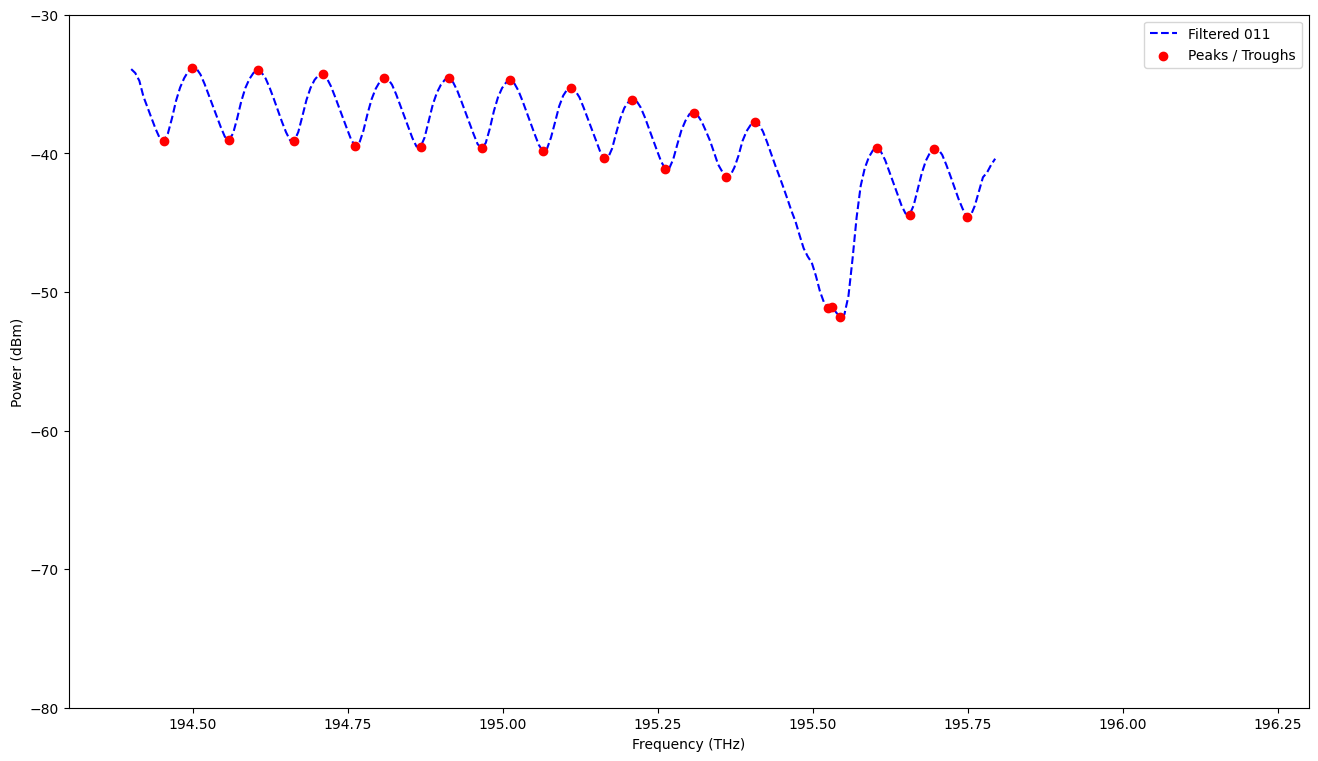

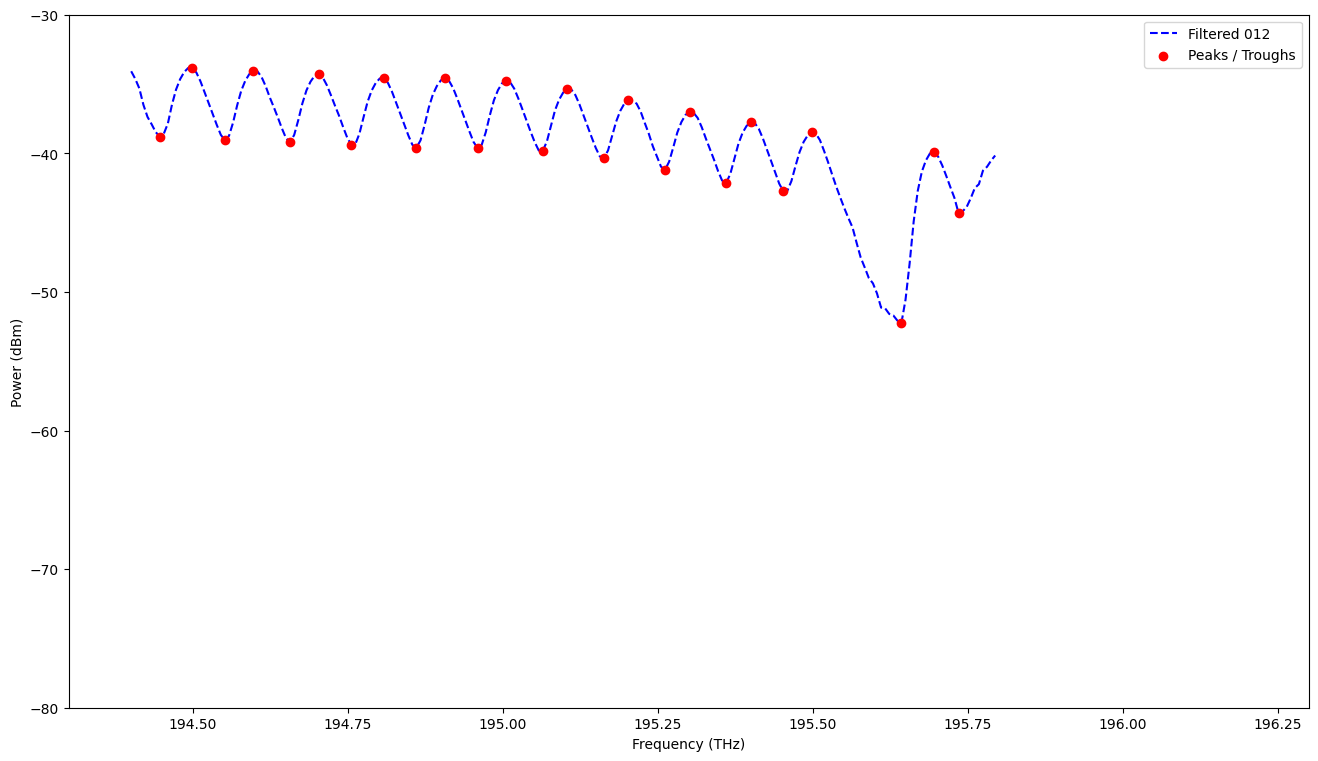

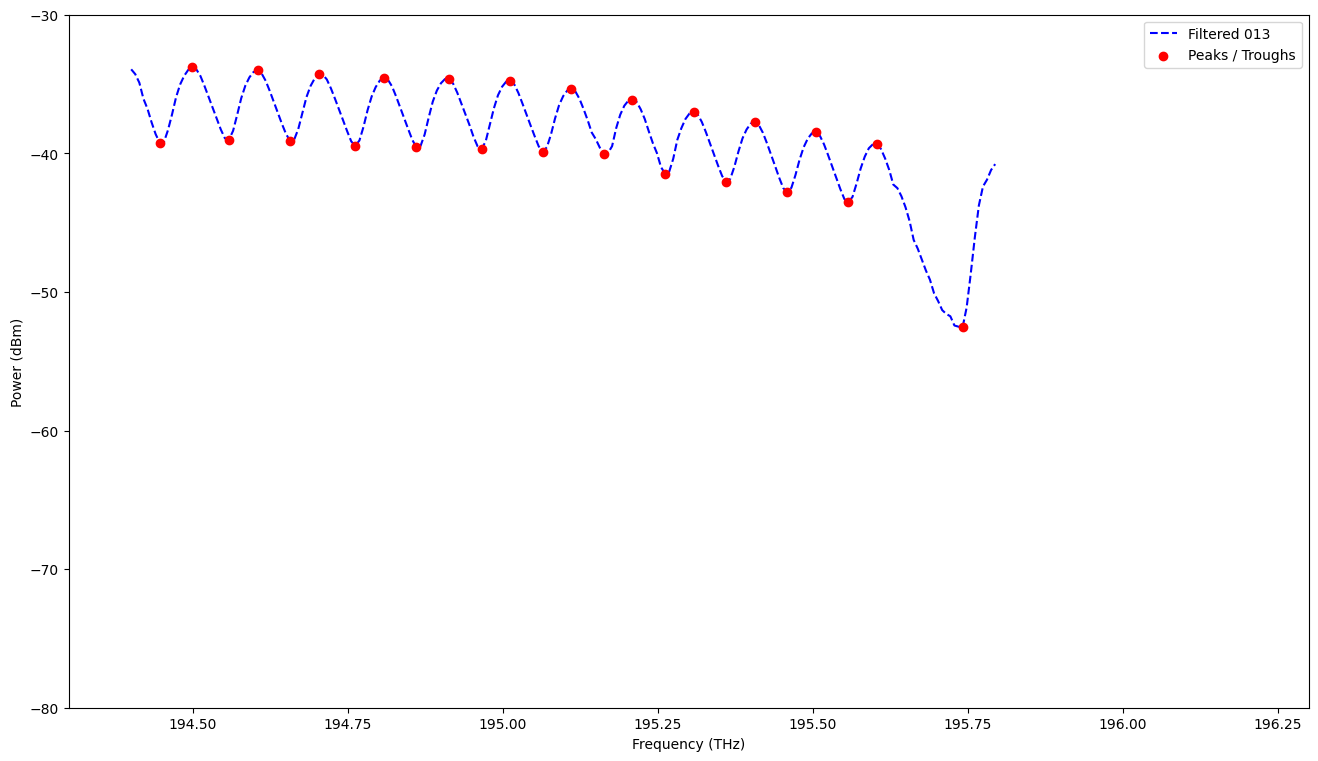

In [10]:
noise_floor = []
for i in range(len(signals)):
    # only look in relevant frequency range
    freq_range = ((freqs[i] > 194.4) & (freqs[i] < 195.8))
    # use this range only
    use_freq = freqs[i][freq_range]
    use_signal = signals[i][freq_range]

    # filter this signal
    filtered_signal = savgol_filter(use_signal, 6, 3) # window size 6, polynomial order 3

    # get the peaks
    peak_indices, _ = find_peaks(filtered_signal)
    # get the troughs
    trough_indices, _ = find_peaks(-filtered_signal)
        
    # we can get the relevant trough for the channel that is turned off
    # this corresponds to the i used (assuming i starting from 0, ignoring the first one)
    if i != 0:
        noise_floor.append(filtered_signal[trough_indices][i - 1])

    # PLOTTING
    fig, ax = plt.subplots(
        1, 1,
        figsize=(16, 9)
    )

    # Plot the fixed signal with the on signal
    ax.plot(use_freq, filtered_signal, color='b', ls='--', label=f'Filtered {i:03}', zorder=1)
    ax.scatter(use_freq[peak_indices], filtered_signal[peak_indices], color='r', label=f'Peaks / Troughs', zorder=2)
    ax.scatter(use_freq[trough_indices], filtered_signal[trough_indices], color='r', zorder=2)
    
    ax.legend()

    ax.set_xlim(194.3, 196.3)
    ax.set_ylim(-80, -30)

    ax.set_ylabel('Power (dBm)')
    ax.set_xlabel('Frequency (THz)')
    
noise_floor = np.array(noise_floor)
print(noise_floor)

This allows us to look at the peaks and troughs for when we have all channels "on" (so the channel sim), and save each channels peak and relative OSNR:

[-33.79745031 -33.99732784 -34.27714518 -34.53793863 -34.63674421
 -34.74419563 -35.31433869 -36.08730042 -37.00680003 -37.72921926
 -38.46694472 -39.43868228 -39.5877337 ]
[-39.11846263 -39.02329043 -39.08452448 -39.3984847  -39.4516088
 -39.61982894 -40.09089137 -40.3638592  -41.10499943 -42.03544198
 -42.75416986 -43.52115839 -44.07576276 -44.62291889]
[-39.07087653 -39.05390745 -39.24150459 -39.42504675 -39.53571887
 -39.85536016 -40.22737529 -40.73442932 -41.5702207  -42.39480592
 -43.13766413 -43.79846057 -44.34934082]
[5.27342622 5.05657961 4.96435941 4.88710812 4.89897466 5.11116452
 4.9130366  4.6471289  4.56342067 4.66558666 4.67071941 4.3597783
 4.76160713]
[14.65947973 14.45509383 15.11637982 13.87571363 14.02278668 14.03533906
 13.94772412 14.0420174  13.7683267  13.59892559 12.6817928  12.7912381
 12.97065174]


Text(0.5, 0, 'Frequency (THz)')

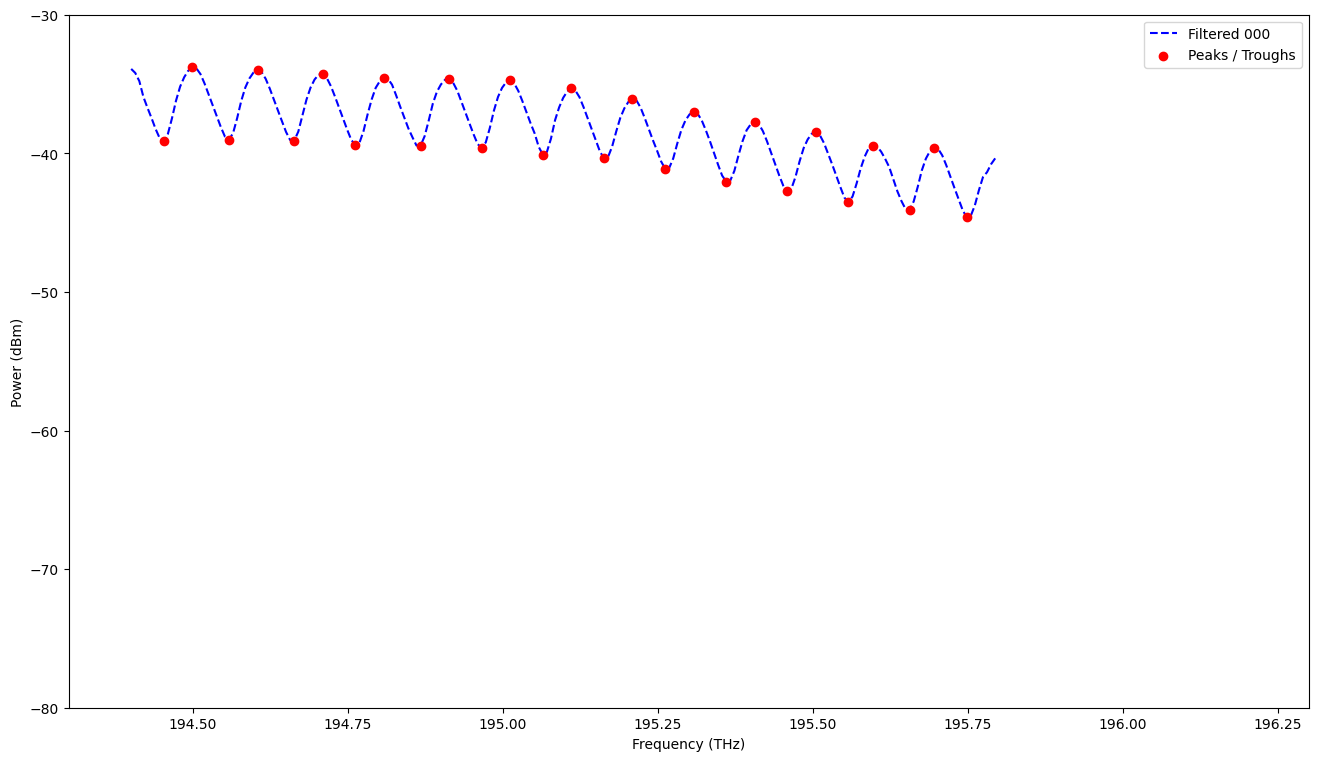

In [13]:
# which signal to use
i = 0

# only look in relevant frequency range
freq_range = ((freqs[i] > 194.4) & (freqs[i] < 195.8))
# use this range only
use_freq = freqs[i][freq_range]
use_signal = signals[i][freq_range]

# filter this signal
filtered_signal = savgol_filter(use_signal, 6, 3) # window size 6, polynomial order 3

# get the peaks
peak_indices, _ = find_peaks(filtered_signal)
# get the troughs
trough_indices, _ = find_peaks(-filtered_signal)

# the peaks are what we use to calculate the OSNR
peaks = filtered_signal[peak_indices]
# we can average every pair of troughs in order to use as the relative noise floor
troughs = filtered_signal[trough_indices]
rel_noise_floor = np.array([(troughs[i] + troughs[i + 1]) / 2 for i in range(len(troughs) - 1)])
# this allows us to calculate the relative OSNRs
rel_OSNRs = peaks - rel_noise_floor
# and get the better estimate OSNR
OSNRs = peaks - noise_floor

print(peaks)
print(troughs)
print(rel_noise_floor)
print(rel_OSNRs)
print(OSNRs)

# PLOTTING
fig, ax = plt.subplots(
    1, 1,
    figsize=(16, 9)
)

# Plot the fixed signal with the on signal
ax.plot(use_freq, filtered_signal, color='b', ls='--', label=f'Filtered {i:03}', zorder=1)
ax.scatter(use_freq[peak_indices], filtered_signal[peak_indices], color='r', label=f'Peaks / Troughs', zorder=2)
ax.scatter(use_freq[trough_indices], filtered_signal[trough_indices], color='r', zorder=2)

ax.legend()

ax.set_xlim(194.3, 196.3)
ax.set_ylim(-80, -30)

ax.set_ylabel('Power (dBm)')
ax.set_xlabel('Frequency (THz)')

If we want to create a `.gif` of these fixed signals, we can do as follows (convert cell to code, but convert back to Raw NBConvert when done):

## COMPARE TO OSA

Since the OSA has kept the same wavelength range throughout, we don't need to perform this signal matching. The resolution is also good enough that we don't need to perform any averaging. This allows us to directly find the peaks and troughs. We import the channel sim OSA Data as follows, with peak and trough estimation in the same range as before. Thus, we obtain the relative OSNRs and the peaks found:

[-39.371 -39.271 -38.42  -37.685 -36.889 -36.104 -35.311 -34.671 -34.621
 -34.554 -34.24  -34.049 -33.874]
[-85.507 -86.723 -86.812 -86.838 -86.419 -84.802 -84.963 -85.258 -84.89
 -84.392 -84.601 -84.556 -84.479 -83.789]
[-86.115  -86.7675 -86.825  -86.6285 -85.6105 -84.8825 -85.1105 -85.074
 -84.641  -84.4965 -84.5785 -84.5175 -84.134 ]
[46.744  47.4965 48.405  48.9435 48.7215 48.7785 49.7995 50.403  50.02
 49.9425 50.3385 50.4685 50.26  ]


Text(0, 0.5, 'Power (dBm)')

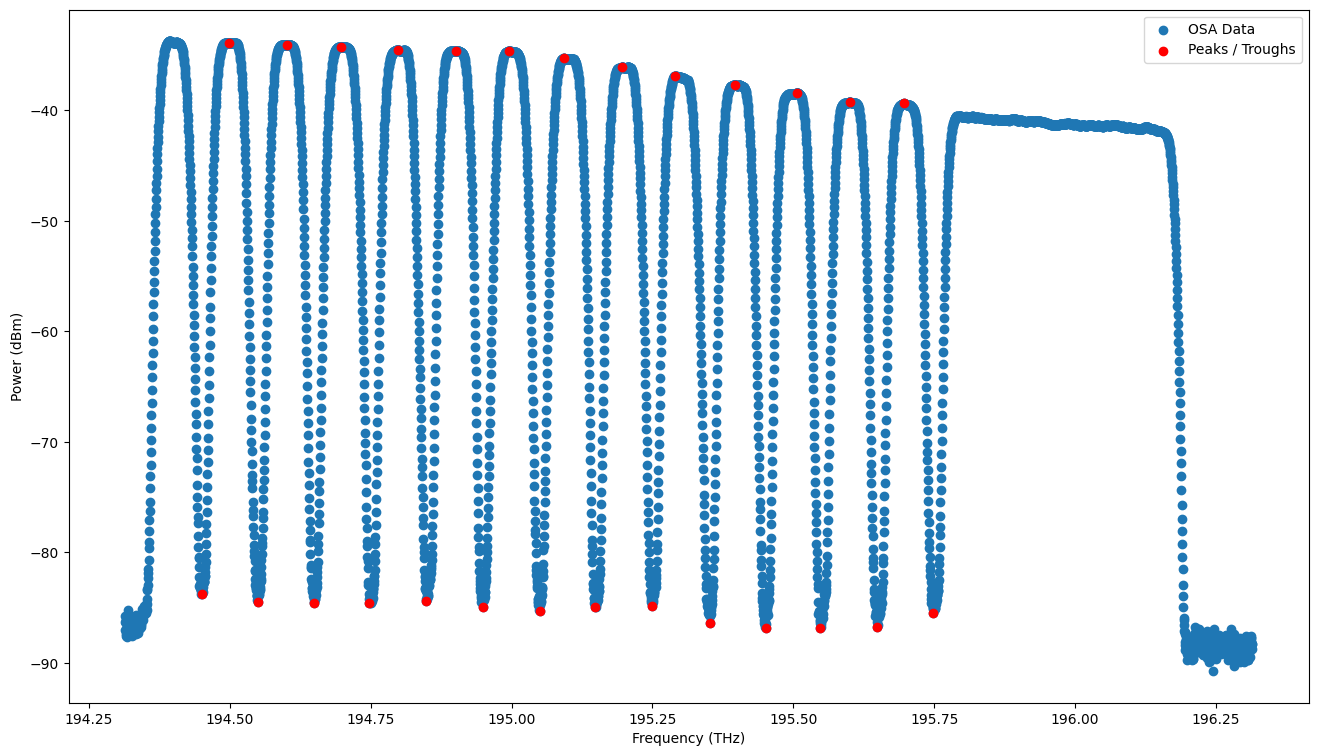

In [12]:
# import the data from the file
# note we have to skip certain rows as they contain settings data
# unpack=True automatically transposes the data so we dont have to
wavelength_nm, power_dBm = np.loadtxt('Data/OSA/OSA_BASIC.CSV', delimiter=',', skiprows=29, unpack=True)

# convert wavelength to frequency
freq_THz = ((2.99792458 * 10**8) / (wavelength_nm * 10**(-9))) * 10**(-12)
# convert dBm to W
power_W = 10**(power_dBm / 10) / 1000

# only look in relevant wavelength / frequency range
freq_range = ((freq_THz > 194.42) & (freq_THz < 195.79))

# get the peaks
# have to set distance so it only takes largest peak 200 samples around it
peak_indices, _ = find_peaks(power_dBm[freq_range], distance=200)
# get the troughs
trough_indices, _ = find_peaks(-power_dBm[freq_range], distance=200)

# the peaks are what we use to calculate the OSNR
peaks = power_dBm[freq_range][peak_indices]
# we can average every pair of troughs in order to use as the relative noise floor
troughs = power_dBm[freq_range][trough_indices]
rel_noise_floor = np.array([(troughs[i] + troughs[i + 1]) / 2 for i in range(len(troughs) - 1)])
# this allows us to calculate the relative OSNRs (dBm so just minus)
rel_OSNRs = peaks - rel_noise_floor

# PRINTING
print(peaks)
print(troughs)
print(rel_noise_floor)
print(rel_OSNRs)

# PLOTTING
fig, ax = plt.subplots(
    1, 1,
    figsize=(16, 9)
)

# Plot the wavelength
ax.scatter(freq_THz, power_dBm, label='OSA Data')
ax.scatter(freq_THz[freq_range][peak_indices], power_dBm[freq_range][peak_indices], color='r', label='Peaks / Troughs')
ax.scatter(freq_THz[freq_range][trough_indices], power_dBm[freq_range][trough_indices], color='r')

ax.legend()

ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Power (dBm)')